In [1]:
# Copyright (c) Microsoft Corporation.
# Licensed under the MIT License.

"""Benchmark all the baseline agents
on a given CyberBattleSim environment and compare
them to the dumb 'random agent' baseline.

NOTE: You can run this `.py`-notebook directly from VSCode.
You can also generate a traditional Jupyter Notebook
using the VSCode command `Export Currenty Python File As Jupyter Notebook`.
"""

# pylint: disable=invalid-name

"Benchmark all the baseline agents\non a given CyberBattleSim environment and compare\nthem to the dumb 'random agent' baseline.\n\nNOTE: You can run this `.py`-notebook directly from VSCode.\nYou can also generate a traditional Jupyter Notebook\nusing the VSCode command `Export Currenty Python File As Jupyter Notebook`.\n"

In [2]:
import sys
import logging
import gym
import cyberbattle.agents.baseline.learner as learner
import cyberbattle.agents.baseline.plotting as p
import cyberbattle.agents.baseline.agent_wrapper as w
import cyberbattle.agents.baseline.agent_randomcredlookup as rca
import cyberbattle.agents.baseline.agent_tabularqlearning as tqa
import cyberbattle.agents.baseline.agent_dql as dqla
from cyberbattle.agents.baseline.agent_wrapper import Verbosity

logging.basicConfig(stream=sys.stdout, level=logging.ERROR, format="%(levelname)s: %(message)s")

In [3]:
# Papermill notebook parameters

#############
# gymid = 'CyberBattleTiny-v0'
#############
gymid = "CyberBattleToyCtf-v0"
env_size = None
iteration_count = 1500
training_episode_count = 20
eval_episode_count = 10
maximum_node_count = 12
maximum_total_credentials = 10
#############
# gymid = "CyberBattleChain-v0"
# env_size = 10
# iteration_count = 9000
# training_episode_count = 50
# eval_episode_count = 5
# maximum_node_count = 22
# maximum_total_credentials = 22

In [4]:
# Parameters
gymid = "CyberBattleTiny-v0"
iteration_count = 200
training_episode_count = 10
eval_episode_count = 10
maximum_node_count = 5
maximum_total_credentials = 3


In [5]:
# Load the Gym environment
if env_size:
    gym_env = gym.make(gymid, size=env_size)
else:
    gym_env = gym.make(gymid)

ep = w.EnvironmentBounds.of_identifiers(
    maximum_node_count=maximum_node_count,
    maximum_total_credentials=maximum_total_credentials,
    identifiers=gym_env.identifiers
)

In [6]:
debugging = False
if debugging:
    print(f"port_count = {ep.port_count}, property_count = {ep.property_count}")

    gym_env.environment
    # training_env.environment.plot_environment_graph()
    gym_env.environment.network.nodes
    gym_env.action_space
    gym_env.action_space.sample()
    gym_env.observation_space.sample()
    o0 = gym_env.reset()
    o_test, r, d, i = gym_env.step(gym_env.sample_valid_action())
    o0 = gym_env.reset()

    o0.keys()

    fe_example = w.RavelEncoding(ep, [w.Feature_active_node_properties(ep), w.Feature_discovered_node_count(ep)])
    a = w.StateAugmentation(o0)
    w.Feature_discovered_ports(ep).get(a, None)
    fe_example.encode_at(a, 0)

###### Credential lookups (ϵ-greedy)
Learning with: episode_count=10,iteration_count=200,ϵ=0.9,ϵ_min=0.1, ϵ_expdecay=10000,
  ## Episode: 1/10 'Credential lookups (ϵ-greedy)' ϵ=0.9000, 


Episode 1|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 1|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 1|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 1|Iteration 21|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 1|Iteration 21|reward:   12.0|last_reward_at:   21|Elapsed Time: 0:00:00||

Episode 1|Iteration 40|reward:   21.0|last_reward_at:   21|Elapsed Time: 0:00:00||

Episode 1|Iteration 40|reward:   21.0|last_reward_at:   40|Elapsed Time: 0:00:00||

Episode 1|Iteration 99|reward:   21.0|last_reward_at:   40|Elapsed Time: 0:00:00||

Episode 1|Iteration 157|reward:   21.0|last_reward_at:   40|Elapsed Time: 0:00:00||

Episode 1|Iteration 200|reward:   21.0|last_reward_at:   40|Elapsed Time: 0:00:00||

  Episode 1 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/93 (0.01)
    explore-remote: 2/84 (0.02)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/20 (0.00)
  exploit deflected to exploration: 4
  ## Episode: 2/10 'Credential lookups (ϵ-greedy)' ϵ=0.8842, 


Episode 2|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 2|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 2|Iteration 4|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 2|Iteration 4|reward:    6.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 2|Iteration 6|reward:   12.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 2|Iteration 6|reward:   12.0|last_reward_at:    6|Elapsed Time: 0:00:00||

Episode 2|Iteration 12|reward:   21.0|last_reward_at:    6|Elapsed Time: 0:00:00||

Episode 2|Iteration 12|reward:   21.0|last_reward_at:   12|Elapsed Time: 0:00:00||

Episode 2|Iteration 71|reward:   21.0|last_reward_at:   12|Elapsed Time: 0:00:00||

Episode 2|Iteration 130|reward:   21.0|last_reward_at:   12|Elapsed Time: 0:00:00||

Episode 2|Iteration 188|reward:   21.0|last_reward_at:   12|Elapsed Time: 0:00:00||

Episode 2|Iteration 200|reward:   21.0|last_reward_at:   12|Elapsed Time: 0:00:00||

  Episode 2 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/92 (0.01)
    explore-remote: 2/82 (0.02)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/23 (0.00)
  exploit deflected to exploration: 1
  ## Episode: 3/10 'Credential lookups (ϵ-greedy)' ϵ=0.8687, 


Episode 3|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 3|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 3|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 3|Iteration 10|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 3|Iteration 10|reward:   12.0|last_reward_at:   10|Elapsed Time: 0:00:00||

Episode 3|Iteration 16|reward:   21.0|last_reward_at:   10|Elapsed Time: 0:00:00||

Episode 3|Iteration 16|reward:   21.0|last_reward_at:   16|Elapsed Time: 0:00:00||

Episode 3|Iteration 74|reward:   21.0|last_reward_at:   16|Elapsed Time: 0:00:00||

Episode 3|Iteration 137|reward:   21.0|last_reward_at:   16|Elapsed Time: 0:00:00||

Episode 3|Iteration 195|reward:   21.0|last_reward_at:   16|Elapsed Time: 0:00:00||

Episode 3|Iteration 200|reward:   21.0|last_reward_at:   16|Elapsed Time: 0:00:00||

  Episode 3 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/82 (0.01)
    explore-remote: 2/94 (0.02)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/21 (0.00)
  exploit deflected to exploration: 2
  ## Episode: 4/10 'Credential lookups (ϵ-greedy)' ϵ=0.8535, 


Episode 4|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 4|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 4|Iteration 3|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 4|Iteration 3|reward:    6.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 4|Iteration 4|reward:   12.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 4|Iteration 4|reward:   12.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 4|Iteration 9|reward:   21.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 4|Iteration 9|reward:   21.0|last_reward_at:    9|Elapsed Time: 0:00:00||

Episode 4|Iteration 69|reward:   21.0|last_reward_at:    9|Elapsed Time: 0:00:00||

Episode 4|Iteration 127|reward:   21.0|last_reward_at:    9|Elapsed Time: 0:00:00||

Episode 4|Iteration 160|reward:   21.0|last_reward_at:    9|Elapsed Time: 0:00:00||

Episode 4|Iteration 200|reward:   21.0|last_reward_at:    9|Elapsed Time: 0:00:00||

  Episode 4 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/73 (0.01)
    explore-remote: 2/89 (0.02)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/35 (0.00)
  exploit deflected to exploration: 1
  ## Episode: 5/10 'Credential lookups (ϵ-greedy)' ϵ=0.8386, 


Episode 5|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 5|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 5|Iteration 3|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 5|Iteration 3|reward:    6.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 5|Iteration 32|reward:   12.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 5|Iteration 32|reward:   12.0|last_reward_at:   32|Elapsed Time: 0:00:00||

Episode 5|Iteration 41|reward:   21.0|last_reward_at:   32|Elapsed Time: 0:00:00||

Episode 5|Iteration 41|reward:   21.0|last_reward_at:   41|Elapsed Time: 0:00:00||

Episode 5|Iteration 97|reward:   21.0|last_reward_at:   41|Elapsed Time: 0:00:00||

Episode 5|Iteration 152|reward:   21.0|last_reward_at:   41|Elapsed Time: 0:00:00||

Episode 5|Iteration 200|reward:   21.0|last_reward_at:   41|Elapsed Time: 0:00:00||

  Episode 5 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/95 (0.01)
    explore-remote: 2/75 (0.03)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/27 (0.00)
  exploit deflected to exploration: 4
  ## Episode: 6/10 'Credential lookups (ϵ-greedy)' ϵ=0.8239, 


Episode 6|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 6|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 6|Iteration 3|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 6|Iteration 3|reward:    6.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 6|Iteration 36|reward:   12.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 6|Iteration 36|reward:   12.0|last_reward_at:   36|Elapsed Time: 0:00:00||

Episode 6|Iteration 39|reward:   21.0|last_reward_at:   36|Elapsed Time: 0:00:00||

Episode 6|Iteration 39|reward:   21.0|last_reward_at:   39|Elapsed Time: 0:00:00||

Episode 6|Iteration 102|reward:   21.0|last_reward_at:   39|Elapsed Time: 0:00:00||

Episode 6|Iteration 160|reward:   21.0|last_reward_at:   39|Elapsed Time: 0:00:00||

Episode 6|Iteration 200|reward:   21.0|last_reward_at:   39|Elapsed Time: 0:00:00||

  Episode 6 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/82 (0.01)
    explore-remote: 2/78 (0.03)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/37 (0.00)
  exploit deflected to exploration: 4
  ## Episode: 7/10 'Credential lookups (ϵ-greedy)' ϵ=0.8096, 


Episode 7|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 7|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 7|Iteration 2|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 7|Iteration 2|reward:    6.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 7|Iteration 19|reward:   12.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 7|Iteration 19|reward:   12.0|last_reward_at:   19|Elapsed Time: 0:00:00||

Episode 7|Iteration 27|reward:   21.0|last_reward_at:   19|Elapsed Time: 0:00:00||

Episode 7|Iteration 27|reward:   21.0|last_reward_at:   27|Elapsed Time: 0:00:00||

Episode 7|Iteration 87|reward:   21.0|last_reward_at:   27|Elapsed Time: 0:00:00||

Episode 7|Iteration 147|reward:   21.0|last_reward_at:   27|Elapsed Time: 0:00:00||

Episode 7|Iteration 200|reward:   21.0|last_reward_at:   27|Elapsed Time: 0:00:00||

  Episode 7 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/87 (0.01)
    explore-remote: 2/73 (0.03)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/37 (0.00)
  exploit deflected to exploration: 7
  ## Episode: 8/10 'Credential lookups (ϵ-greedy)' ϵ=0.7956, 


Episode 8|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 8|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 8|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 8|Iteration 5|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 8|Iteration 5|reward:   12.0|last_reward_at:    5|Elapsed Time: 0:00:00||

Episode 8|Iteration 69|reward:   12.0|last_reward_at:    5|Elapsed Time: 0:00:00||

Episode 8|Iteration 71|reward:   21.0|last_reward_at:    5|Elapsed Time: 0:00:00||

Episode 8|Iteration 71|reward:   21.0|last_reward_at:   71|Elapsed Time: 0:00:00||

Episode 8|Iteration 137|reward:   21.0|last_reward_at:   71|Elapsed Time: 0:00:00||

Episode 8|Iteration 195|reward:   21.0|last_reward_at:   71|Elapsed Time: 0:00:00||

Episode 8|Iteration 200|reward:   21.0|last_reward_at:   71|Elapsed Time: 0:00:00||

  Episode 8 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/86 (0.01)
    explore-remote: 2/86 (0.02)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/25 (0.00)
  exploit deflected to exploration: 13
  ## Episode: 9/10 'Credential lookups (ϵ-greedy)' ϵ=0.7818, 


Episode 9|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 9|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 9|Iteration 2|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 9|Iteration 2|reward:    6.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 9|Iteration 3|reward:   12.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 9|Iteration 3|reward:   12.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 9|Iteration 7|reward:   21.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 9|Iteration 7|reward:   21.0|last_reward_at:    7|Elapsed Time: 0:00:00||

Episode 9|Iteration 66|reward:   21.0|last_reward_at:    7|Elapsed Time: 0:00:00||

Episode 9|Iteration 127|reward:   21.0|last_reward_at:    7|Elapsed Time: 0:00:00||

Episode 9|Iteration 188|reward:   21.0|last_reward_at:    7|Elapsed Time: 0:00:00||

Episode 9|Iteration 200|reward:   21.0|last_reward_at:    7|Elapsed Time: 0:00:00||

  Episode 9 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/78 (0.01)
    explore-remote: 2/68 (0.03)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/51 (0.00)
  exploit deflected to exploration: 3
  ## Episode: 10/10 'Credential lookups (ϵ-greedy)' ϵ=0.7683, 


Episode 10|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 10|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 10|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 10|Iteration 5|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 10|Iteration 5|reward:   12.0|last_reward_at:    5|Elapsed Time: 0:00:00||

Episode 10|Iteration 18|reward:   21.0|last_reward_at:    5|Elapsed Time: 0:00:00||

Episode 10|Iteration 18|reward:   21.0|last_reward_at:   18|Elapsed Time: 0:00:00||

Episode 10|Iteration 82|reward:   21.0|last_reward_at:   18|Elapsed Time: 0:00:00||

Episode 10|Iteration 127|reward:   21.0|last_reward_at:   18|Elapsed Time: 0:00:00||

Episode 10|Iteration 185|reward:   21.0|last_reward_at:   18|Elapsed Time: 0:00:00||

Episode 10|Iteration 200|reward:   21.0|last_reward_at:   18|Elapsed Time: 0:00:00||

  Episode 10 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/71 (0.01)
    explore-remote: 2/76 (0.03)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/50 (0.00)
  exploit deflected to exploration: 8
simulation ended


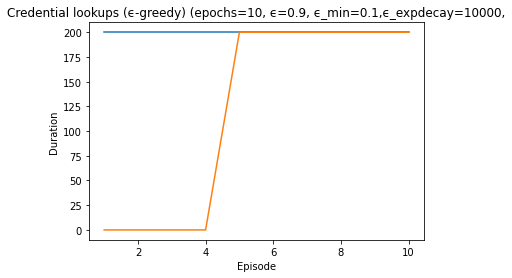

In [7]:
# Evaluate a random agent that opportunistically exploits
# credentials gathere in its local cache
credlookup_run = learner.epsilon_greedy_search(
    gym_env,
    ep,
    learner=rca.CredentialCacheExploiter(),
    episode_count=10,
    iteration_count=iteration_count,
    epsilon=0.90,
    render=False,
    epsilon_exponential_decay=10000,
    epsilon_minimum=0.10,
    verbosity=Verbosity.Quiet,
    title="Credential lookups (ϵ-greedy)"
)

In [8]:
# Evaluate a Tabular Q-learning agent
tabularq_run = learner.epsilon_greedy_search(
    gym_env,
    ep,
    learner=tqa.QTabularLearner(
        ep,
        gamma=0.015, learning_rate=0.01, exploit_percentile=100),
    episode_count=training_episode_count,
    iteration_count=iteration_count,
    epsilon=0.90,
    epsilon_exponential_decay=5000,
    epsilon_minimum=0.01,
    verbosity=Verbosity.Quiet,
    render=False,
    plot_episodes_length=False,
    title="Tabular Q-learning"
)

###### Tabular Q-learning
Learning with: episode_count=10,iteration_count=200,ϵ=0.9,ϵ_min=0.01, ϵ_expdecay=5000,γ=0.015,learning_rate=0.01,Q%=100
  ## Episode: 1/10 'Tabular Q-learning' ϵ=0.9000, γ=0.015,learning_rate=0.01,Q%=100


Episode 1|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 1|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 1|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 1|Iteration 5|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 1|Iteration 5|reward:   12.0|last_reward_at:    5|Elapsed Time: 0:00:00||

Episode 1|Iteration 11|reward:   21.0|last_reward_at:    5|Elapsed Time: 0:00:00||

Episode 1|Iteration 11|reward:   21.0|last_reward_at:   11|Elapsed Time: 0:00:00||

Episode 1|Iteration 17|reward: 1021.0|last_reward_at:   11|Elapsed Time: 0:00:00||

Episode 1|Iteration 17|reward: 1021.0|last_reward_at:   17|Elapsed Time: 0:00:00||

Episode 1|Iteration 44|reward: 1021.0|last_reward_at:   17|Elapsed Time: 0:00:00||

Episode 1|Iteration 76|reward: 1021.0|last_reward_at:   17|Elapsed Time: 0:00:00||

Episode 1|Iteration 107|reward: 1021.0|last_reward_at:   17|Elapsed Time: 0:00:00||

Episode 1|Iteration 135|reward: 1021.0|last_reward_at:   17|Elapsed Time: 0:00:00||

Episode 1|Iteration 163|reward: 1021.0|last_reward_at:   17|Elapsed Time: 0:00:00||

Episode 1|Iteration 193|reward: 1021.0|last_reward_at:   17|Elapsed Time: 0:00:00||

Episode 1|Iteration 200|reward: 1021.0|last_reward_at:   17|Elapsed Time: 0:00:00||

  Episode 1 stopped at t=200 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/46 (0.02)
    explore-remote: 2/73 (0.03)
    explore-connect: 1/74 (0.01)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/3 (0.00)
  exploit deflected to exploration: 20
  ## Episode: 2/10 'Tabular Q-learning' ϵ=0.8653, γ=0.015,learning_rate=0.01,Q%=100


Episode 2|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 2|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 2|Iteration 2|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 2|Iteration 2|reward:    6.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 2|Iteration 10|reward:   12.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 2|Iteration 10|reward:   12.0|last_reward_at:   10|Elapsed Time: 0:00:00||

Episode 2|Iteration 27|reward:   21.0|last_reward_at:   10|Elapsed Time: 0:00:00||

Episode 2|Iteration 27|reward:   21.0|last_reward_at:   27|Elapsed Time: 0:00:00||

Episode 2|Iteration 49|reward: 1021.0|last_reward_at:   27|Elapsed Time: 0:00:00||

Episode 2|Iteration 49|reward: 1021.0|last_reward_at:   49|Elapsed Time: 0:00:00||

Episode 2|Iteration 82|reward: 1021.0|last_reward_at:   49|Elapsed Time: 0:00:00||

Episode 2|Iteration 112|reward: 1021.0|last_reward_at:   49|Elapsed Time: 0:00:00||

Episode 2|Iteration 142|reward: 1021.0|last_reward_at:   49|Elapsed Time: 0:00:00||

Episode 2|Iteration 170|reward: 1021.0|last_reward_at:   49|Elapsed Time: 0:00:00||

Episode 2|Iteration 198|reward: 1021.0|last_reward_at:   49|Elapsed Time: 0:00:00||

Episode 2|Iteration 200|reward: 1021.0|last_reward_at:   49|Elapsed Time: 0:00:00||

  Episode 2 stopped at t=200 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/49 (0.02)
    explore-remote: 2/75 (0.03)
    explore-connect: 1/69 (0.01)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/3 (0.00)
  exploit deflected to exploration: 20
  ## Episode: 3/10 'Tabular Q-learning' ϵ=0.8317, γ=0.015,learning_rate=0.01,Q%=100


Episode 3|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 3|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 3|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 3|Iteration 3|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 3|Iteration 3|reward:   12.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 3|Iteration 16|reward:   21.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 3|Iteration 16|reward:   21.0|last_reward_at:   16|Elapsed Time: 0:00:00||

Episode 3|Iteration 20|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:00||

Episode 3|Iteration 20|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:00||

Episode 3|Iteration 49|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:00||

Episode 3|Iteration 79|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:00||

Episode 3|Iteration 109|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:00||

Episode 3|Iteration 140|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:00||

Episode 3|Iteration 170|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:00||

Episode 3|Iteration 200|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:00||

  Episode 3 stopped at t=200 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/41 (0.02)
    explore-remote: 2/70 (0.03)
    explore-connect: 1/85 (0.01)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 32
  ## Episode: 4/10 'Tabular Q-learning' ϵ=0.7995, γ=0.015,learning_rate=0.01,Q%=100


Episode 4|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 4|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 4|Iteration 2|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 4|Iteration 2|reward:    6.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 4|Iteration 3|reward:   12.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 4|Iteration 3|reward:   12.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 4|Iteration 22|reward:   21.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 4|Iteration 22|reward:   21.0|last_reward_at:   22|Elapsed Time: 0:00:00||

Episode 4|Iteration 37|reward: 1021.0|last_reward_at:   22|Elapsed Time: 0:00:00||

Episode 4|Iteration 37|reward: 1021.0|last_reward_at:   37|Elapsed Time: 0:00:00||

Episode 4|Iteration 69|reward: 1021.0|last_reward_at:   37|Elapsed Time: 0:00:00||

Episode 4|Iteration 99|reward: 1021.0|last_reward_at:   37|Elapsed Time: 0:00:00||

Episode 4|Iteration 127|reward: 1021.0|last_reward_at:   37|Elapsed Time: 0:00:00||

Episode 4|Iteration 155|reward: 1021.0|last_reward_at:   37|Elapsed Time: 0:00:00||

Episode 4|Iteration 185|reward: 1021.0|last_reward_at:   37|Elapsed Time: 0:00:00||

Episode 4|Iteration 200|reward: 1021.0|last_reward_at:   37|Elapsed Time: 0:00:00||

  Episode 4 stopped at t=200 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/43 (0.00)
    explore-remote: 1/75 (0.01)
    explore-connect: 1/73 (0.01)
    exploit-local: 1/0 (1.00)
    exploit-remote: 1/1 (0.50)
    exploit-connect: 0/4 (0.00)
  exploit deflected to exploration: 38
  ## Episode: 5/10 'Tabular Q-learning' ϵ=0.7686, γ=0.015,learning_rate=0.01,Q%=100


Episode 5|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 5|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 5|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 5|Iteration 4|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 5|Iteration 4|reward:   12.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 5|Iteration 33|reward:   12.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 5|Iteration 64|reward:   12.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 5|Iteration 78|reward:   21.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 5|Iteration 78|reward:   21.0|last_reward_at:   78|Elapsed Time: 0:00:00||

Episode 5|Iteration 92|reward:   21.0|last_reward_at:   78|Elapsed Time: 0:00:00||

Episode 5|Iteration 127|reward:   21.0|last_reward_at:   78|Elapsed Time: 0:00:00||

Episode 5|Iteration 144|reward: 1021.0|last_reward_at:   78|Elapsed Time: 0:00:00||

Episode 5|Iteration 144|reward: 1021.0|last_reward_at:  144|Elapsed Time: 0:00:00||

Episode 5|Iteration 170|reward: 1021.0|last_reward_at:  144|Elapsed Time: 0:00:00||

Episode 5|Iteration 200|reward: 1021.0|last_reward_at:  144|Elapsed Time: 0:00:00||

  Episode 5 stopped at t=200 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/62 (0.02)
    explore-remote: 1/69 (0.01)
    explore-connect: 1/40 (0.02)
    exploit-local: 0/0 (NaN)
    exploit-remote: 1/1 (0.50)
    exploit-connect: 0/24 (0.00)
  exploit deflected to exploration: 34
  ## Episode: 6/10 'Tabular Q-learning' ϵ=0.7388, γ=0.015,learning_rate=0.01,Q%=100


Episode 6|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 6|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 6|Iteration 2|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 6|Iteration 2|reward:    6.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 6|Iteration 9|reward:   12.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 6|Iteration 9|reward:   12.0|last_reward_at:    9|Elapsed Time: 0:00:00||

Episode 6|Iteration 14|reward:   21.0|last_reward_at:    9|Elapsed Time: 0:00:00||

Episode 6|Iteration 14|reward:   21.0|last_reward_at:   14|Elapsed Time: 0:00:00||

Episode 6|Iteration 22|reward: 1021.0|last_reward_at:   14|Elapsed Time: 0:00:00||

Episode 6|Iteration 22|reward: 1021.0|last_reward_at:   22|Elapsed Time: 0:00:00||

Episode 6|Iteration 54|reward: 1021.0|last_reward_at:   22|Elapsed Time: 0:00:00||

Episode 6|Iteration 84|reward: 1021.0|last_reward_at:   22|Elapsed Time: 0:00:00||

Episode 6|Iteration 117|reward: 1021.0|last_reward_at:   22|Elapsed Time: 0:00:00||

Episode 6|Iteration 145|reward: 1021.0|last_reward_at:   22|Elapsed Time: 0:00:00||

Episode 6|Iteration 173|reward: 1021.0|last_reward_at:   22|Elapsed Time: 0:00:00||

Episode 6|Iteration 200|reward: 1021.0|last_reward_at:   22|Elapsed Time: 0:00:00||

  Episode 6 stopped at t=200 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/40 (0.02)
    explore-remote: 1/80 (0.01)
    explore-connect: 1/75 (0.01)
    exploit-local: 0/0 (NaN)
    exploit-remote: 1/0 (1.00)
    exploit-connect: 0/1 (0.00)
  exploit deflected to exploration: 42
  ## Episode: 7/10 'Tabular Q-learning' ϵ=0.7102, γ=0.015,learning_rate=0.01,Q%=100


Episode 7|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 7|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 7|Iteration 2|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 7|Iteration 2|reward:    6.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 7|Iteration 6|reward:   12.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 7|Iteration 6|reward:   12.0|last_reward_at:    6|Elapsed Time: 0:00:00||

Episode 7|Iteration 18|reward:   21.0|last_reward_at:    6|Elapsed Time: 0:00:00||

Episode 7|Iteration 18|reward:   21.0|last_reward_at:   18|Elapsed Time: 0:00:00||

Episode 7|Iteration 23|reward: 1021.0|last_reward_at:   18|Elapsed Time: 0:00:00||

Episode 7|Iteration 23|reward: 1021.0|last_reward_at:   23|Elapsed Time: 0:00:00||

Episode 7|Iteration 54|reward: 1021.0|last_reward_at:   23|Elapsed Time: 0:00:00||

Episode 7|Iteration 82|reward: 1021.0|last_reward_at:   23|Elapsed Time: 0:00:00||

Episode 7|Iteration 112|reward: 1021.0|last_reward_at:   23|Elapsed Time: 0:00:00||

Episode 7|Iteration 140|reward: 1021.0|last_reward_at:   23|Elapsed Time: 0:00:00||

Episode 7|Iteration 168|reward: 1021.0|last_reward_at:   23|Elapsed Time: 0:00:00||

Episode 7|Iteration 195|reward: 1021.0|last_reward_at:   23|Elapsed Time: 0:00:00||

Episode 7|Iteration 200|reward: 1021.0|last_reward_at:   23|Elapsed Time: 0:00:00||

  Episode 7 stopped at t=200 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/46 (0.02)
    explore-remote: 2/81 (0.02)
    explore-connect: 1/69 (0.01)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 60
  ## Episode: 8/10 'Tabular Q-learning' ϵ=0.6828, γ=0.015,learning_rate=0.01,Q%=100


Episode 8|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 8|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 8|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 8|Iteration 2|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 8|Iteration 2|reward:   12.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 8|Iteration 5|reward:   21.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 8|Iteration 5|reward:   21.0|last_reward_at:    5|Elapsed Time: 0:00:00||

Episode 8|Iteration 16|reward: 1021.0|last_reward_at:    5|Elapsed Time: 0:00:00||

Episode 8|Iteration 16|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:00||

Episode 8|Iteration 41|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:00||

Episode 8|Iteration 71|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:00||

Episode 8|Iteration 99|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:00||

Episode 8|Iteration 127|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:00||

Episode 8|Iteration 155|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:00||

Episode 8|Iteration 183|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:00||

Episode 8|Iteration 200|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:00||

  Episode 8 stopped at t=200 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/46 (0.02)
    explore-remote: 1/76 (0.01)
    explore-connect: 1/70 (0.01)
    exploit-local: 0/0 (NaN)
    exploit-remote: 1/1 (0.50)
    exploit-connect: 0/3 (0.00)
  exploit deflected to exploration: 60
  ## Episode: 9/10 'Tabular Q-learning' ϵ=0.6564, γ=0.015,learning_rate=0.01,Q%=100


Episode 9|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 9|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 9|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 9|Iteration 2|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 9|Iteration 2|reward:   12.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 9|Iteration 23|reward:   21.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 9|Iteration 23|reward:   21.0|last_reward_at:   23|Elapsed Time: 0:00:00||

Episode 9|Iteration 48|reward: 1021.0|last_reward_at:   23|Elapsed Time: 0:00:00||

Episode 9|Iteration 48|reward: 1021.0|last_reward_at:   48|Elapsed Time: 0:00:00||

Episode 9|Iteration 76|reward: 1021.0|last_reward_at:   48|Elapsed Time: 0:00:00||

Episode 9|Iteration 104|reward: 1021.0|last_reward_at:   48|Elapsed Time: 0:00:00||

Episode 9|Iteration 132|reward: 1021.0|last_reward_at:   48|Elapsed Time: 0:00:00||

Episode 9|Iteration 160|reward: 1021.0|last_reward_at:   48|Elapsed Time: 0:00:00||

Episode 9|Iteration 188|reward: 1021.0|last_reward_at:   48|Elapsed Time: 0:00:00||

Episode 9|Iteration 200|reward: 1021.0|last_reward_at:   48|Elapsed Time: 0:00:00||

  Episode 9 stopped at t=200 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/47 (0.00)
    explore-remote: 1/74 (0.01)
    explore-connect: 1/66 (0.01)
    exploit-local: 1/0 (1.00)
    exploit-remote: 1/0 (1.00)
    exploit-connect: 0/9 (0.00)
  exploit deflected to exploration: 71
  ## Episode: 10/10 'Tabular Q-learning' ϵ=0.6311, γ=0.015,learning_rate=0.01,Q%=100


Episode 10|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 10|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 10|Iteration 2|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 10|Iteration 2|reward:    6.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 10|Iteration 3|reward:   12.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 10|Iteration 3|reward:   12.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 10|Iteration 4|reward:   21.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 10|Iteration 4|reward:   21.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 10|Iteration 41|reward:   21.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 10|Iteration 76|reward:   21.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 10|Iteration 87|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 10|Iteration 87|reward: 1021.0|last_reward_at:   87|Elapsed Time: 0:00:00||

Episode 10|Iteration 117|reward: 1021.0|last_reward_at:   87|Elapsed Time: 0:00:00||

Episode 10|Iteration 145|reward: 1021.0|last_reward_at:   87|Elapsed Time: 0:00:00||

Episode 10|Iteration 173|reward: 1021.0|last_reward_at:   87|Elapsed Time: 0:00:00||

Episode 10|Iteration 200|reward: 1021.0|last_reward_at:   87|Elapsed Time: 0:00:00||

  Episode 10 stopped at t=200 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/37 (0.03)
    explore-remote: 1/63 (0.02)
    explore-connect: 1/61 (0.02)
    exploit-local: 0/0 (NaN)
    exploit-remote: 1/1 (0.50)
    exploit-connect: 0/34 (0.00)
  exploit deflected to exploration: 41
simulation ended


###### Exploiting Q-matrix
Learning with: episode_count=10,iteration_count=200,ϵ=0.0,ϵ_min=0.0, γ=0.0,learning_rate=0.0,Q%=90
  ## Episode: 1/10 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=90


Episode 1|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 1|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 1|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 1|Iteration 2|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 1|Iteration 2|reward:   12.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 1|Iteration 23|reward:   12.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 1|Iteration 24|reward:   21.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 1|Iteration 24|reward:   21.0|last_reward_at:   24|Elapsed Time: 0:00:00||

Episode 1|Iteration 59|reward:   21.0|last_reward_at:   24|Elapsed Time: 0:00:00||

Episode 1|Iteration 92|reward:   21.0|last_reward_at:   24|Elapsed Time: 0:00:00||

Episode 1|Iteration 125|reward:   21.0|last_reward_at:   24|Elapsed Time: 0:00:00||

Episode 1|Iteration 160|reward:   21.0|last_reward_at:   24|Elapsed Time: 0:00:00||

Episode 1|Iteration 195|reward:   21.0|last_reward_at:   24|Elapsed Time: 0:00:00||

Episode 1|Iteration 200|reward:   21.0|last_reward_at:   24|Elapsed Time: 0:00:00||

  Episode 1 stopped at t=200 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/10 (0.00)
    explore-remote: 1/11 (0.08)
    explore-connect: 0/0 (NaN)
    exploit-local: 1/0 (1.00)
    exploit-remote: 1/0 (1.00)
    exploit-connect: 0/176 (0.00)
  exploit deflected to exploration: 22
  ## Episode: 2/10 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=90


Episode 2|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 2|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 2|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 2|Iteration 2|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 2|Iteration 2|reward:   12.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 2|Iteration 14|reward:   21.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 2|Iteration 14|reward:   21.0|last_reward_at:   14|Elapsed Time: 0:00:00||

Episode 2|Iteration 49|reward:   21.0|last_reward_at:   14|Elapsed Time: 0:00:00||

Episode 2|Iteration 79|reward:   21.0|last_reward_at:   14|Elapsed Time: 0:00:00||

Episode 2|Iteration 112|reward:   21.0|last_reward_at:   14|Elapsed Time: 0:00:00||

Episode 2|Iteration 145|reward:   21.0|last_reward_at:   14|Elapsed Time: 0:00:00||

Episode 2|Iteration 180|reward:   21.0|last_reward_at:   14|Elapsed Time: 0:00:00||

Episode 2|Iteration 200|reward:   21.0|last_reward_at:   14|Elapsed Time: 0:00:00||

  Episode 2 stopped at t=200 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/5 (0.00)
    explore-remote: 1/6 (0.14)
    explore-connect: 0/0 (NaN)
    exploit-local: 1/0 (1.00)
    exploit-remote: 1/0 (1.00)
    exploit-connect: 0/186 (0.00)
  exploit deflected to exploration: 12
  ## Episode: 3/10 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=90


Episode 3|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 3|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 3|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 3|Iteration 2|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 3|Iteration 2|reward:   12.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 3|Iteration 13|reward:   21.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 3|Iteration 13|reward:   21.0|last_reward_at:   13|Elapsed Time: 0:00:00||

Episode 3|Iteration 49|reward:   21.0|last_reward_at:   13|Elapsed Time: 0:00:00||

Episode 3|Iteration 84|reward:   21.0|last_reward_at:   13|Elapsed Time: 0:00:00||

Episode 3|Iteration 119|reward:   21.0|last_reward_at:   13|Elapsed Time: 0:00:00||

Episode 3|Iteration 152|reward:   21.0|last_reward_at:   13|Elapsed Time: 0:00:00||

Episode 3|Iteration 185|reward:   21.0|last_reward_at:   13|Elapsed Time: 0:00:00||

Episode 3|Iteration 200|reward:   21.0|last_reward_at:   13|Elapsed Time: 0:00:00||

  Episode 3 stopped at t=200 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/5 (0.00)
    explore-remote: 1/5 (0.17)
    explore-connect: 0/0 (NaN)
    exploit-local: 1/0 (1.00)
    exploit-remote: 1/0 (1.00)
    exploit-connect: 0/187 (0.00)
  exploit deflected to exploration: 11
  ## Episode: 4/10 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=90


Episode 4|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 4|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 4|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 4|Iteration 2|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 4|Iteration 2|reward:   12.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 4|Iteration 9|reward:   21.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 4|Iteration 9|reward:   21.0|last_reward_at:    9|Elapsed Time: 0:00:00||

Episode 4|Iteration 44|reward:   21.0|last_reward_at:    9|Elapsed Time: 0:00:00||

Episode 4|Iteration 79|reward:   21.0|last_reward_at:    9|Elapsed Time: 0:00:00||

Episode 4|Iteration 114|reward:   21.0|last_reward_at:    9|Elapsed Time: 0:00:00||

Episode 4|Iteration 147|reward:   21.0|last_reward_at:    9|Elapsed Time: 0:00:00||

Episode 4|Iteration 183|reward:   21.0|last_reward_at:    9|Elapsed Time: 0:00:00||

Episode 4|Iteration 200|reward:   21.0|last_reward_at:    9|Elapsed Time: 0:00:00||

  Episode 4 stopped at t=200 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/1 (0.00)
    explore-remote: 1/5 (0.17)
    explore-connect: 0/0 (NaN)
    exploit-local: 1/0 (1.00)
    exploit-remote: 1/0 (1.00)
    exploit-connect: 0/191 (0.00)
  exploit deflected to exploration: 7
  ## Episode: 5/10 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=90


Episode 5|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 5|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 5|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 5|Iteration 2|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 5|Iteration 2|reward:   12.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 5|Iteration 18|reward:   21.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 5|Iteration 18|reward:   21.0|last_reward_at:   18|Elapsed Time: 0:00:00||

Episode 5|Iteration 54|reward:   21.0|last_reward_at:   18|Elapsed Time: 0:00:00||

Episode 5|Iteration 89|reward:   21.0|last_reward_at:   18|Elapsed Time: 0:00:00||

Episode 5|Iteration 125|reward:   21.0|last_reward_at:   18|Elapsed Time: 0:00:00||

Episode 5|Iteration 157|reward:   21.0|last_reward_at:   18|Elapsed Time: 0:00:00||

Episode 5|Iteration 193|reward:   21.0|last_reward_at:   18|Elapsed Time: 0:00:00||

Episode 5|Iteration 200|reward:   21.0|last_reward_at:   18|Elapsed Time: 0:00:00||

  Episode 5 stopped at t=200 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/7 (0.00)
    explore-remote: 1/8 (0.11)
    explore-connect: 0/0 (NaN)
    exploit-local: 1/0 (1.00)
    exploit-remote: 1/0 (1.00)
    exploit-connect: 0/182 (0.00)
  exploit deflected to exploration: 16
  ## Episode: 6/10 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=90


Episode 6|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 6|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 6|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 6|Iteration 2|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 6|Iteration 2|reward:   12.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 6|Iteration 3|reward:   21.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 6|Iteration 3|reward:   21.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 6|Iteration 36|reward:   21.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 6|Iteration 69|reward:   21.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 6|Iteration 87|reward:   21.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 6|Iteration 119|reward:   21.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 6|Iteration 155|reward:   21.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 6|Iteration 188|reward:   21.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 6|Iteration 200|reward:   21.0|last_reward_at:    3|Elapsed Time: 0:00:00||

  Episode 6 stopped at t=200 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/0 (NaN)
    explore-remote: 1/0 (1.00)
    explore-connect: 0/0 (NaN)
    exploit-local: 1/0 (1.00)
    exploit-remote: 1/0 (1.00)
    exploit-connect: 0/197 (0.00)
  exploit deflected to exploration: 1
  ## Episode: 7/10 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=90


Episode 7|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 7|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 7|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 7|Iteration 2|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 7|Iteration 2|reward:   12.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 7|Iteration 26|reward:   12.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 7|Iteration 26|reward:   21.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 7|Iteration 26|reward:   21.0|last_reward_at:   26|Elapsed Time: 0:00:00||

Episode 7|Iteration 59|reward:   21.0|last_reward_at:   26|Elapsed Time: 0:00:00||

Episode 7|Iteration 92|reward:   21.0|last_reward_at:   26|Elapsed Time: 0:00:00||

Episode 7|Iteration 125|reward:   21.0|last_reward_at:   26|Elapsed Time: 0:00:00||

Episode 7|Iteration 157|reward:   21.0|last_reward_at:   26|Elapsed Time: 0:00:00||

Episode 7|Iteration 188|reward:   21.0|last_reward_at:   26|Elapsed Time: 0:00:00||

Episode 7|Iteration 200|reward:   21.0|last_reward_at:   26|Elapsed Time: 0:00:00||

  Episode 7 stopped at t=200 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/18 (0.00)
    explore-remote: 1/5 (0.17)
    explore-connect: 0/0 (NaN)
    exploit-local: 1/0 (1.00)
    exploit-remote: 1/0 (1.00)
    exploit-connect: 0/174 (0.00)
  exploit deflected to exploration: 24
  ## Episode: 8/10 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=90


Episode 8|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 8|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 8|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 8|Iteration 2|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 8|Iteration 2|reward:   12.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 8|Iteration 15|reward:   21.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 8|Iteration 15|reward:   21.0|last_reward_at:   15|Elapsed Time: 0:00:00||

Episode 8|Iteration 44|reward:   21.0|last_reward_at:   15|Elapsed Time: 0:00:00||

Episode 8|Iteration 74|reward:   21.0|last_reward_at:   15|Elapsed Time: 0:00:00||

Episode 8|Iteration 107|reward:   21.0|last_reward_at:   15|Elapsed Time: 0:00:00||

Episode 8|Iteration 140|reward:   21.0|last_reward_at:   15|Elapsed Time: 0:00:00||

Episode 8|Iteration 173|reward:   21.0|last_reward_at:   15|Elapsed Time: 0:00:00||

Episode 8|Iteration 200|reward:   21.0|last_reward_at:   15|Elapsed Time: 0:00:00||

  Episode 8 stopped at t=200 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/10 (0.00)
    explore-remote: 1/2 (0.33)
    explore-connect: 0/0 (NaN)
    exploit-local: 1/0 (1.00)
    exploit-remote: 1/0 (1.00)
    exploit-connect: 0/185 (0.00)
  exploit deflected to exploration: 13
  ## Episode: 9/10 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=90


Episode 9|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 9|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 9|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 9|Iteration 2|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 9|Iteration 2|reward:   12.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 9|Iteration 19|reward:   21.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 9|Iteration 19|reward:   21.0|last_reward_at:   19|Elapsed Time: 0:00:00||

Episode 9|Iteration 54|reward:   21.0|last_reward_at:   19|Elapsed Time: 0:00:00||

Episode 9|Iteration 89|reward:   21.0|last_reward_at:   19|Elapsed Time: 0:00:00||

Episode 9|Iteration 122|reward:   21.0|last_reward_at:   19|Elapsed Time: 0:00:00||

Episode 9|Iteration 155|reward:   21.0|last_reward_at:   19|Elapsed Time: 0:00:00||

Episode 9|Iteration 188|reward:   21.0|last_reward_at:   19|Elapsed Time: 0:00:00||

Episode 9|Iteration 200|reward:   21.0|last_reward_at:   19|Elapsed Time: 0:00:00||

  Episode 9 stopped at t=200 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/4 (0.00)
    explore-remote: 1/12 (0.08)
    explore-connect: 0/0 (NaN)
    exploit-local: 1/0 (1.00)
    exploit-remote: 1/0 (1.00)
    exploit-connect: 0/181 (0.00)
  exploit deflected to exploration: 17
  ## Episode: 10/10 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=90


Episode 10|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 10|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 10|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 10|Iteration 2|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 10|Iteration 2|reward:   12.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 10|Iteration 3|reward:   21.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 10|Iteration 3|reward:   21.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 10|Iteration 36|reward:   21.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 10|Iteration 69|reward:   21.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 10|Iteration 104|reward:   21.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 10|Iteration 137|reward:   21.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 10|Iteration 170|reward:   21.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 10|Iteration 200|reward:   21.0|last_reward_at:    3|Elapsed Time: 0:00:00||

  Episode 10 stopped at t=200 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/0 (NaN)
    explore-remote: 1/0 (1.00)
    explore-connect: 0/0 (NaN)
    exploit-local: 1/0 (1.00)
    exploit-remote: 1/0 (1.00)
    exploit-connect: 0/197 (0.00)
  exploit deflected to exploration: 1
simulation ended


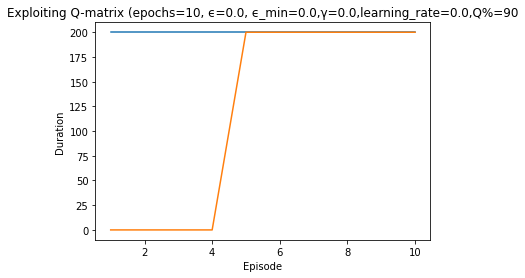

In [9]:
# Evaluate an agent that exploits the Q-table learnt above
tabularq_exploit_run = learner.epsilon_greedy_search(
    gym_env,
    ep,
    learner=tqa.QTabularLearner(
        ep,
        trained=tabularq_run['learner'],
        gamma=0.0,
        learning_rate=0.0,
        exploit_percentile=90),
    episode_count=eval_episode_count,
    iteration_count=iteration_count,
    epsilon=0.0,
    render=False,
    verbosity=Verbosity.Quiet,
    title="Exploiting Q-matrix"
)

In [10]:
# Evaluate the Deep Q-learning agent
dql_run = learner.epsilon_greedy_search(
    cyberbattle_gym_env=gym_env,
    environment_properties=ep,
    learner=dqla.DeepQLearnerPolicy(
        ep=ep,
        gamma=0.015,
        replay_memory_size=10000,
        target_update=10,
        batch_size=512,
        # torch default learning rate is 1e-2
        # a large value helps converge in less episodes
        learning_rate=0.01
    ),
    episode_count=training_episode_count,
    iteration_count=iteration_count,
    epsilon=0.90,
    epsilon_exponential_decay=5000,
    epsilon_minimum=0.10,
    verbosity=Verbosity.Quiet,
    render=False,
    plot_episodes_length=False,
    title="DQL"
)

###### DQL
Learning with: episode_count=10,iteration_count=200,ϵ=0.9,ϵ_min=0.1, ϵ_expdecay=5000,γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10
  ## Episode: 1/10 'DQL' ϵ=0.9000, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 1|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 1|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 1|Iteration 2|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 1|Iteration 2|reward:    6.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 1|Iteration 11|reward:   12.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 1|Iteration 11|reward:   12.0|last_reward_at:   11|Elapsed Time: 0:00:00||

Episode 1|Iteration 23|reward:   21.0|last_reward_at:   11|Elapsed Time: 0:00:00||

Episode 1|Iteration 23|reward:   21.0|last_reward_at:   23|Elapsed Time: 0:00:00||

Episode 1|Iteration 54|reward:   21.0|last_reward_at:   23|Elapsed Time: 0:00:00||

Episode 1|Iteration 79|reward: 1021.0|last_reward_at:   23|Elapsed Time: 0:00:00||

Episode 1|Iteration 79|reward: 1021.0|last_reward_at:   79|Elapsed Time: 0:00:00||

Episode 1|Iteration 104|reward: 1021.0|last_reward_at:   79|Elapsed Time: 0:00:00||

Episode 1|Iteration 130|reward: 1021.0|last_reward_at:   79|Elapsed Time: 0:00:00||

Episode 1|Iteration 160|reward: 1021.0|last_reward_at:   79|Elapsed Time: 0:00:00||

Episode 1|Iteration 188|reward: 1021.0|last_reward_at:   79|Elapsed Time: 0:00:00||

Episode 1|Iteration 200|reward: 1021.0|last_reward_at:   79|Elapsed Time: 0:00:00||

  Episode 1 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/42 (0.02)
    explore-remote: 2/82 (0.02)
    explore-connect: 1/69 (0.01)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/3 (0.00)
  exploit deflected to exploration: 15
  ## Episode: 2/10 'DQL' ϵ=0.8688, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 2|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 2|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 2|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 2|Iteration 20|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 2|Iteration 20|reward:   12.0|last_reward_at:   20|Elapsed Time: 0:00:00||

Episode 2|Iteration 38|reward:   21.0|last_reward_at:   20|Elapsed Time: 0:00:00||

Episode 2|Iteration 38|reward:   21.0|last_reward_at:   38|Elapsed Time: 0:00:00||

Episode 2|Iteration 64|reward:   21.0|last_reward_at:   38|Elapsed Time: 0:00:00||

Episode 2|Iteration 65|reward: 1021.0|last_reward_at:   38|Elapsed Time: 0:00:00||

Episode 2|Iteration 65|reward: 1021.0|last_reward_at:   65|Elapsed Time: 0:00:00||

Episode 2|Iteration 87|reward: 1021.0|last_reward_at:   65|Elapsed Time: 0:00:00||

Episode 2|Iteration 114|reward: 1021.0|last_reward_at:   65|Elapsed Time: 0:00:00||

Episode 2|Iteration 140|reward: 1021.0|last_reward_at:   65|Elapsed Time: 0:00:00||

Episode 2|Iteration 165|reward: 1021.0|last_reward_at:   65|Elapsed Time: 0:00:00||

Episode 2|Iteration 190|reward: 1021.0|last_reward_at:   65|Elapsed Time: 0:00:00||

Episode 2|Iteration 200|reward: 1021.0|last_reward_at:   65|Elapsed Time: 0:00:00||

  Episode 2 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/47 (0.02)
    explore-remote: 2/81 (0.02)
    explore-connect: 1/63 (0.02)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/5 (0.00)
  exploit deflected to exploration: 23
  ## Episode: 3/10 'DQL' ϵ=0.8386, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 3|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 3|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 3|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 3|Iteration 3|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 3|Iteration 3|reward:   12.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 3|Iteration 4|reward:   21.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 3|Iteration 4|reward:   21.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 3|Iteration 5|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 3|Iteration 5|reward: 1021.0|last_reward_at:    5|Elapsed Time: 0:00:00||

Episode 3|Iteration 28|reward: 1021.0|last_reward_at:    5|Elapsed Time: 0:00:00||

Episode 3|Iteration 38|reward: 1021.0|last_reward_at:    5|Elapsed Time: 0:00:00||

Episode 3|Iteration 44|reward: 1021.0|last_reward_at:    5|Elapsed Time: 0:00:00||

Episode 3|Iteration 49|reward: 1021.0|last_reward_at:    5|Elapsed Time: 0:00:00||

Episode 3|Iteration 56|reward: 1021.0|last_reward_at:    5|Elapsed Time: 0:00:00||

Episode 3|Iteration 61|reward: 1021.0|last_reward_at:    5|Elapsed Time: 0:00:00||

Episode 3|Iteration 69|reward: 1021.0|last_reward_at:    5|Elapsed Time: 0:00:00||

Episode 3|Iteration 74|reward: 1021.0|last_reward_at:    5|Elapsed Time: 0:00:00||

Episode 3|Iteration 82|reward: 1021.0|last_reward_at:    5|Elapsed Time: 0:00:00||

Episode 3|Iteration 89|reward: 1021.0|last_reward_at:    5|Elapsed Time: 0:00:00||

Episode 3|Iteration 97|reward: 1021.0|last_reward_at:    5|Elapsed Time: 0:00:00||

Episode 3|Iteration 104|reward: 1021.0|last_reward_at:    5|Elapsed Time: 0:00:00||

Episode 3|Iteration 112|reward: 1021.0|last_reward_at:    5|Elapsed Time: 0:00:00||

Episode 3|Iteration 119|reward: 1021.0|last_reward_at:    5|Elapsed Time: 0:00:00||

Episode 3|Iteration 125|reward: 1021.0|last_reward_at:    5|Elapsed Time: 0:00:00||

Episode 3|Iteration 132|reward: 1021.0|last_reward_at:    5|Elapsed Time: 0:00:01||

Episode 3|Iteration 140|reward: 1021.0|last_reward_at:    5|Elapsed Time: 0:00:01||

Episode 3|Iteration 147|reward: 1021.0|last_reward_at:    5|Elapsed Time: 0:00:01||

Episode 3|Iteration 152|reward: 1021.0|last_reward_at:    5|Elapsed Time: 0:00:01||

Episode 3|Iteration 160|reward: 1021.0|last_reward_at:    5|Elapsed Time: 0:00:01||

Episode 3|Iteration 168|reward: 1021.0|last_reward_at:    5|Elapsed Time: 0:00:01||

Episode 3|Iteration 173|reward: 1021.0|last_reward_at:    5|Elapsed Time: 0:00:01||

Episode 3|Iteration 180|reward: 1021.0|last_reward_at:    5|Elapsed Time: 0:00:01||

Episode 3|Iteration 188|reward: 1021.0|last_reward_at:    5|Elapsed Time: 0:00:01||

Episode 3|Iteration 193|reward: 1021.0|last_reward_at:    5|Elapsed Time: 0:00:01||

Episode 3|Iteration 200|reward: 1021.0|last_reward_at:    5|Elapsed Time: 0:00:01||

  Episode 3 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/33 (0.03)
    explore-remote: 2/72 (0.03)
    explore-connect: 0/76 (0.00)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/15 (0.00)
    exploit-connect: 1/0 (1.00)
  exploit deflected to exploration: 11
  ## Episode: 4/10 'DQL' ϵ=0.8097, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 4|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 4|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 4|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 4|Iteration 3|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 4|Iteration 3|reward:   12.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 4|Iteration 11|reward:   12.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 4|Iteration 17|reward:   21.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 4|Iteration 17|reward:   21.0|last_reward_at:   17|Elapsed Time: 0:00:00||

Episode 4|Iteration 20|reward: 1021.0|last_reward_at:   17|Elapsed Time: 0:00:00||

Episode 4|Iteration 20|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:00||

Episode 4|Iteration 28|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:00||

Episode 4|Iteration 36|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:00||

Episode 4|Iteration 44|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:00||

Episode 4|Iteration 51|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:00||

Episode 4|Iteration 59|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:00||

Episode 4|Iteration 66|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:00||

Episode 4|Iteration 74|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:00||

Episode 4|Iteration 82|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:00||

Episode 4|Iteration 87|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:00||

Episode 4|Iteration 92|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:00||

Episode 4|Iteration 97|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:00||

Episode 4|Iteration 104|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:00||

Episode 4|Iteration 109|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:01||

Episode 4|Iteration 114|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:01||

Episode 4|Iteration 122|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:01||

Episode 4|Iteration 130|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:01||

Episode 4|Iteration 137|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:01||

Episode 4|Iteration 142|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:01||

Episode 4|Iteration 150|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:01||

Episode 4|Iteration 155|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:01||

Episode 4|Iteration 160|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:01||

Episode 4|Iteration 168|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:01||

Episode 4|Iteration 175|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:01||

Episode 4|Iteration 183|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:01||

Episode 4|Iteration 190|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:01||

Episode 4|Iteration 198|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:01||

Episode 4|Iteration 200|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:01||

  Episode 4 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/43 (0.02)
    explore-remote: 1/67 (0.01)
    explore-connect: 0/65 (0.00)
    exploit-local: 0/0 (NaN)
    exploit-remote: 1/21 (0.05)
    exploit-connect: 1/0 (1.00)
  exploit deflected to exploration: 17
  ## Episode: 5/10 'DQL' ϵ=0.7819, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 5|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 5|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 5|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 5|Iteration 8|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 5|Iteration 12|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 5|Iteration 12|reward:   12.0|last_reward_at:   12|Elapsed Time: 0:00:00||

Episode 5|Iteration 21|reward:   12.0|last_reward_at:   12|Elapsed Time: 0:00:00||

Episode 5|Iteration 21|reward:   21.0|last_reward_at:   12|Elapsed Time: 0:00:00||

Episode 5|Iteration 21|reward:   21.0|last_reward_at:   21|Elapsed Time: 0:00:00||

Episode 5|Iteration 31|reward:   21.0|last_reward_at:   21|Elapsed Time: 0:00:00||

Episode 5|Iteration 37|reward: 1021.0|last_reward_at:   21|Elapsed Time: 0:00:00||

Episode 5|Iteration 37|reward: 1021.0|last_reward_at:   37|Elapsed Time: 0:00:00||

Episode 5|Iteration 44|reward: 1021.0|last_reward_at:   37|Elapsed Time: 0:00:00||

Episode 5|Iteration 49|reward: 1021.0|last_reward_at:   37|Elapsed Time: 0:00:00||

Episode 5|Iteration 56|reward: 1021.0|last_reward_at:   37|Elapsed Time: 0:00:00||

Episode 5|Iteration 64|reward: 1021.0|last_reward_at:   37|Elapsed Time: 0:00:00||

Episode 5|Iteration 71|reward: 1021.0|last_reward_at:   37|Elapsed Time: 0:00:00||

Episode 5|Iteration 79|reward: 1021.0|last_reward_at:   37|Elapsed Time: 0:00:00||

Episode 5|Iteration 87|reward: 1021.0|last_reward_at:   37|Elapsed Time: 0:00:00||

Episode 5|Iteration 92|reward: 1021.0|last_reward_at:   37|Elapsed Time: 0:00:00||

Episode 5|Iteration 97|reward: 1021.0|last_reward_at:   37|Elapsed Time: 0:00:00||

Episode 5|Iteration 104|reward: 1021.0|last_reward_at:   37|Elapsed Time: 0:00:00||

Episode 5|Iteration 112|reward: 1021.0|last_reward_at:   37|Elapsed Time: 0:00:00||

Episode 5|Iteration 119|reward: 1021.0|last_reward_at:   37|Elapsed Time: 0:00:01||

Episode 5|Iteration 127|reward: 1021.0|last_reward_at:   37|Elapsed Time: 0:00:01||

Episode 5|Iteration 135|reward: 1021.0|last_reward_at:   37|Elapsed Time: 0:00:01||

Episode 5|Iteration 142|reward: 1021.0|last_reward_at:   37|Elapsed Time: 0:00:01||

Episode 5|Iteration 150|reward: 1021.0|last_reward_at:   37|Elapsed Time: 0:00:01||

Episode 5|Iteration 155|reward: 1021.0|last_reward_at:   37|Elapsed Time: 0:00:01||

Episode 5|Iteration 160|reward: 1021.0|last_reward_at:   37|Elapsed Time: 0:00:01||

Episode 5|Iteration 165|reward: 1021.0|last_reward_at:   37|Elapsed Time: 0:00:01||

Episode 5|Iteration 170|reward: 1021.0|last_reward_at:   37|Elapsed Time: 0:00:01||

Episode 5|Iteration 178|reward: 1021.0|last_reward_at:   37|Elapsed Time: 0:00:01||

Episode 5|Iteration 185|reward: 1021.0|last_reward_at:   37|Elapsed Time: 0:00:01||

Episode 5|Iteration 193|reward: 1021.0|last_reward_at:   37|Elapsed Time: 0:00:01||

Episode 5|Iteration 198|reward: 1021.0|last_reward_at:   37|Elapsed Time: 0:00:01||

Episode 5|Iteration 200|reward: 1021.0|last_reward_at:   37|Elapsed Time: 0:00:01||

  Episode 5 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/39 (0.03)
    explore-remote: 2/69 (0.03)
    explore-connect: 1/62 (0.02)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/26 (0.00)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 12
  ## Episode: 6/10 'DQL' ϵ=0.7551, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 6|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 6|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 6|Iteration 2|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 6|Iteration 2|reward:    6.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 6|Iteration 10|reward:   12.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 6|Iteration 10|reward:   12.0|last_reward_at:   10|Elapsed Time: 0:00:00||

Episode 6|Iteration 15|reward:   21.0|last_reward_at:   10|Elapsed Time: 0:00:00||

Episode 6|Iteration 15|reward:   21.0|last_reward_at:   15|Elapsed Time: 0:00:00||

Episode 6|Iteration 18|reward: 1021.0|last_reward_at:   15|Elapsed Time: 0:00:00||

Episode 6|Iteration 18|reward: 1021.0|last_reward_at:   18|Elapsed Time: 0:00:00||

Episode 6|Iteration 26|reward: 1021.0|last_reward_at:   18|Elapsed Time: 0:00:00||

Episode 6|Iteration 33|reward: 1021.0|last_reward_at:   18|Elapsed Time: 0:00:00||

Episode 6|Iteration 41|reward: 1021.0|last_reward_at:   18|Elapsed Time: 0:00:00||

Episode 6|Iteration 46|reward: 1021.0|last_reward_at:   18|Elapsed Time: 0:00:00||

Episode 6|Iteration 54|reward: 1021.0|last_reward_at:   18|Elapsed Time: 0:00:00||

Episode 6|Iteration 61|reward: 1021.0|last_reward_at:   18|Elapsed Time: 0:00:00||

Episode 6|Iteration 64|reward: 1021.0|last_reward_at:   18|Elapsed Time: 0:00:00||

Episode 6|Iteration 71|reward: 1021.0|last_reward_at:   18|Elapsed Time: 0:00:00||

Episode 6|Iteration 79|reward: 1021.0|last_reward_at:   18|Elapsed Time: 0:00:00||

Episode 6|Iteration 87|reward: 1021.0|last_reward_at:   18|Elapsed Time: 0:00:00||

Episode 6|Iteration 92|reward: 1021.0|last_reward_at:   18|Elapsed Time: 0:00:00||

Episode 6|Iteration 99|reward: 1021.0|last_reward_at:   18|Elapsed Time: 0:00:00||

Episode 6|Iteration 107|reward: 1021.0|last_reward_at:   18|Elapsed Time: 0:00:01||

Episode 6|Iteration 114|reward: 1021.0|last_reward_at:   18|Elapsed Time: 0:00:01||

Episode 6|Iteration 119|reward: 1021.0|last_reward_at:   18|Elapsed Time: 0:00:01||

Episode 6|Iteration 125|reward: 1021.0|last_reward_at:   18|Elapsed Time: 0:00:01||

Episode 6|Iteration 130|reward: 1021.0|last_reward_at:   18|Elapsed Time: 0:00:01||

Episode 6|Iteration 135|reward: 1021.0|last_reward_at:   18|Elapsed Time: 0:00:01||

Episode 6|Iteration 140|reward: 1021.0|last_reward_at:   18|Elapsed Time: 0:00:01||

Episode 6|Iteration 145|reward: 1021.0|last_reward_at:   18|Elapsed Time: 0:00:01||

Episode 6|Iteration 152|reward: 1021.0|last_reward_at:   18|Elapsed Time: 0:00:01||

Episode 6|Iteration 160|reward: 1021.0|last_reward_at:   18|Elapsed Time: 0:00:01||

Episode 6|Iteration 163|reward: 1021.0|last_reward_at:   18|Elapsed Time: 0:00:01||

Episode 6|Iteration 168|reward: 1021.0|last_reward_at:   18|Elapsed Time: 0:00:01||

Episode 6|Iteration 175|reward: 1021.0|last_reward_at:   18|Elapsed Time: 0:00:01||

Episode 6|Iteration 180|reward: 1021.0|last_reward_at:   18|Elapsed Time: 0:00:01||

Episode 6|Iteration 183|reward: 1021.0|last_reward_at:   18|Elapsed Time: 0:00:01||

Episode 6|Iteration 188|reward: 1021.0|last_reward_at:   18|Elapsed Time: 0:00:01||

Episode 6|Iteration 193|reward: 1021.0|last_reward_at:   18|Elapsed Time: 0:00:01||

Episode 6|Iteration 198|reward: 1021.0|last_reward_at:   18|Elapsed Time: 0:00:02||

Episode 6|Iteration 200|reward: 1021.0|last_reward_at:   18|Elapsed Time: 0:00:02||

  Episode 6 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/36 (0.03)
    explore-remote: 1/61 (0.02)
    explore-connect: 0/67 (0.00)
    exploit-local: 0/1 (0.00)
    exploit-remote: 1/31 (0.03)
    exploit-connect: 1/0 (1.00)
  exploit deflected to exploration: 26
  ## Episode: 7/10 'DQL' ϵ=0.7294, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 7|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 7|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 7|Iteration 4|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 7|Iteration 4|reward:    6.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 7|Iteration 6|reward:   12.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 7|Iteration 6|reward:   12.0|last_reward_at:    6|Elapsed Time: 0:00:00||

Episode 7|Iteration 11|reward:   21.0|last_reward_at:    6|Elapsed Time: 0:00:00||

Episode 7|Iteration 11|reward:   21.0|last_reward_at:   11|Elapsed Time: 0:00:00||

Episode 7|Iteration 16|reward: 1021.0|last_reward_at:   11|Elapsed Time: 0:00:00||

Episode 7|Iteration 16|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:00||

Episode 7|Iteration 23|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:00||

Episode 7|Iteration 28|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:00||

Episode 7|Iteration 36|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:00||

Episode 7|Iteration 41|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:00||

Episode 7|Iteration 49|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:00||

Episode 7|Iteration 56|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:00||

Episode 7|Iteration 61|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:00||

Episode 7|Iteration 66|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:00||

Episode 7|Iteration 71|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:00||

Episode 7|Iteration 79|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:00||

Episode 7|Iteration 87|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:00||

Episode 7|Iteration 94|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:00||

Episode 7|Iteration 99|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:00||

Episode 7|Iteration 107|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:00||

Episode 7|Iteration 112|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:01||

Episode 7|Iteration 119|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:01||

Episode 7|Iteration 125|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:01||

Episode 7|Iteration 132|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:01||

Episode 7|Iteration 140|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:01||

Episode 7|Iteration 145|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:01||

Episode 7|Iteration 150|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:01||

Episode 7|Iteration 155|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:01||

Episode 7|Iteration 160|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:01||

Episode 7|Iteration 168|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:01||

Episode 7|Iteration 173|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:01||

Episode 7|Iteration 180|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:01||

Episode 7|Iteration 188|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:01||

Episode 7|Iteration 195|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:01||

Episode 7|Iteration 200|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:01||

  Episode 7 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/36 (0.00)
    explore-remote: 1/62 (0.02)
    explore-connect: 0/62 (0.00)
    exploit-local: 1/0 (1.00)
    exploit-remote: 1/36 (0.03)
    exploit-connect: 1/0 (1.00)
  exploit deflected to exploration: 17
  ## Episode: 8/10 'DQL' ϵ=0.7047, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 8|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 8|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 8|Iteration 2|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 8|Iteration 2|reward:    6.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 8|Iteration 3|reward:   12.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 8|Iteration 3|reward:   12.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 8|Iteration 5|reward:   21.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 8|Iteration 5|reward:   21.0|last_reward_at:    5|Elapsed Time: 0:00:00||

Episode 8|Iteration 7|reward: 1021.0|last_reward_at:    5|Elapsed Time: 0:00:00||

Episode 8|Iteration 7|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:00||

Episode 8|Iteration 16|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:00||

Episode 8|Iteration 21|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:00||

Episode 8|Iteration 28|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:00||

Episode 8|Iteration 36|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:00||

Episode 8|Iteration 44|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:00||

Episode 8|Iteration 49|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:00||

Episode 8|Iteration 56|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:00||

Episode 8|Iteration 61|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:00||

Episode 8|Iteration 69|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:00||

Episode 8|Iteration 74|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:00||

Episode 8|Iteration 82|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:00||

Episode 8|Iteration 87|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:00||

Episode 8|Iteration 92|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:00||

Episode 8|Iteration 99|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:00||

Episode 8|Iteration 104|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:01||

Episode 8|Iteration 112|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:01||

Episode 8|Iteration 117|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:01||

Episode 8|Iteration 125|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:01||

Episode 8|Iteration 130|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:01||

Episode 8|Iteration 137|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:01||

Episode 8|Iteration 145|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:01||

Episode 8|Iteration 150|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:01||

Episode 8|Iteration 155|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:01||

Episode 8|Iteration 160|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:01||

Episode 8|Iteration 168|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:01||

Episode 8|Iteration 175|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:01||

Episode 8|Iteration 183|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:01||

Episode 8|Iteration 188|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:01||

Episode 8|Iteration 193|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:01||

Episode 8|Iteration 198|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:02||

Episode 8|Iteration 200|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:02||

  Episode 8 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/32 (0.03)
    explore-remote: 0/60 (0.00)
    explore-connect: 0/66 (0.00)
    exploit-local: 0/0 (NaN)
    exploit-remote: 2/38 (0.05)
    exploit-connect: 1/0 (1.00)
  exploit deflected to exploration: 26
  ## Episode: 9/10 'DQL' ϵ=0.6810, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 9|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 9|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 9|Iteration 2|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 9|Iteration 2|reward:    6.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 9|Iteration 3|reward:   12.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 9|Iteration 3|reward:   12.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 9|Iteration 10|reward:   12.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 9|Iteration 14|reward:   21.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 9|Iteration 14|reward:   21.0|last_reward_at:   14|Elapsed Time: 0:00:00||

Episode 9|Iteration 21|reward:   21.0|last_reward_at:   14|Elapsed Time: 0:00:00||

Episode 9|Iteration 28|reward:   21.0|last_reward_at:   14|Elapsed Time: 0:00:00||

Episode 9|Iteration 32|reward: 1021.0|last_reward_at:   14|Elapsed Time: 0:00:00||

Episode 9|Iteration 32|reward: 1021.0|last_reward_at:   32|Elapsed Time: 0:00:00||

Episode 9|Iteration 41|reward: 1021.0|last_reward_at:   32|Elapsed Time: 0:00:00||

Episode 9|Iteration 49|reward: 1021.0|last_reward_at:   32|Elapsed Time: 0:00:00||

Episode 9|Iteration 56|reward: 1021.0|last_reward_at:   32|Elapsed Time: 0:00:00||

Episode 9|Iteration 61|reward: 1021.0|last_reward_at:   32|Elapsed Time: 0:00:00||

Episode 9|Iteration 66|reward: 1021.0|last_reward_at:   32|Elapsed Time: 0:00:00||

Episode 9|Iteration 69|reward: 1021.0|last_reward_at:   32|Elapsed Time: 0:00:00||

Episode 9|Iteration 74|reward: 1021.0|last_reward_at:   32|Elapsed Time: 0:00:00||

Episode 9|Iteration 81|reward: 1021.0|last_reward_at:   32|Elapsed Time: 0:00:00||

Episode 9|Iteration 89|reward: 1021.0|last_reward_at:   32|Elapsed Time: 0:00:00||

Episode 9|Iteration 94|reward: 1021.0|last_reward_at:   32|Elapsed Time: 0:00:01||

Episode 9|Iteration 102|reward: 1021.0|last_reward_at:   32|Elapsed Time: 0:00:01||

Episode 9|Iteration 109|reward: 1021.0|last_reward_at:   32|Elapsed Time: 0:00:01||

Episode 9|Iteration 114|reward: 1021.0|last_reward_at:   32|Elapsed Time: 0:00:01||

Episode 9|Iteration 122|reward: 1021.0|last_reward_at:   32|Elapsed Time: 0:00:01||

Episode 9|Iteration 125|reward: 1021.0|last_reward_at:   32|Elapsed Time: 0:00:01||

Episode 9|Iteration 130|reward: 1021.0|last_reward_at:   32|Elapsed Time: 0:00:01||

Episode 9|Iteration 137|reward: 1021.0|last_reward_at:   32|Elapsed Time: 0:00:01||

Episode 9|Iteration 142|reward: 1021.0|last_reward_at:   32|Elapsed Time: 0:00:01||

Episode 9|Iteration 147|reward: 1021.0|last_reward_at:   32|Elapsed Time: 0:00:01||

Episode 9|Iteration 152|reward: 1021.0|last_reward_at:   32|Elapsed Time: 0:00:01||

Episode 9|Iteration 160|reward: 1021.0|last_reward_at:   32|Elapsed Time: 0:00:01||

Episode 9|Iteration 168|reward: 1021.0|last_reward_at:   32|Elapsed Time: 0:00:01||

Episode 9|Iteration 175|reward: 1021.0|last_reward_at:   32|Elapsed Time: 0:00:01||

Episode 9|Iteration 182|reward: 1021.0|last_reward_at:   32|Elapsed Time: 0:00:01||

Episode 9|Iteration 190|reward: 1021.0|last_reward_at:   32|Elapsed Time: 0:00:02||

Episode 9|Iteration 195|reward: 1021.0|last_reward_at:   32|Elapsed Time: 0:00:02||

Episode 9|Iteration 200|reward: 1021.0|last_reward_at:   32|Elapsed Time: 0:00:02||

  Episode 9 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/34 (0.00)
    explore-remote: 0/66 (0.00)
    explore-connect: 0/53 (0.00)
    exploit-local: 1/0 (1.00)
    exploit-remote: 2/43 (0.04)
    exploit-connect: 1/0 (1.00)
  exploit deflected to exploration: 26
  ## Episode: 10/10 'DQL' ϵ=0.6583, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 10|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 10|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 10|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 10|Iteration 3|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 10|Iteration 3|reward:   12.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 10|Iteration 11|reward:   12.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 10|Iteration 16|reward:   12.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 10|Iteration 17|reward:   21.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 10|Iteration 17|reward:   21.0|last_reward_at:   17|Elapsed Time: 0:00:00||

Episode 10|Iteration 26|reward:   21.0|last_reward_at:   17|Elapsed Time: 0:00:00||

Episode 10|Iteration 33|reward:   21.0|last_reward_at:   17|Elapsed Time: 0:00:00||

Episode 10|Iteration 41|reward:   21.0|last_reward_at:   17|Elapsed Time: 0:00:00||

Episode 10|Iteration 49|reward:   21.0|last_reward_at:   17|Elapsed Time: 0:00:00||

Episode 10|Iteration 56|reward:   21.0|last_reward_at:   17|Elapsed Time: 0:00:00||

Episode 10|Iteration 64|reward:   21.0|last_reward_at:   17|Elapsed Time: 0:00:00||

Episode 10|Iteration 66|reward: 1021.0|last_reward_at:   17|Elapsed Time: 0:00:00||

Episode 10|Iteration 66|reward: 1021.0|last_reward_at:   66|Elapsed Time: 0:00:00||

Episode 10|Iteration 74|reward: 1021.0|last_reward_at:   66|Elapsed Time: 0:00:00||

Episode 10|Iteration 79|reward: 1021.0|last_reward_at:   66|Elapsed Time: 0:00:00||

Episode 10|Iteration 87|reward: 1021.0|last_reward_at:   66|Elapsed Time: 0:00:00||

Episode 10|Iteration 94|reward: 1021.0|last_reward_at:   66|Elapsed Time: 0:00:00||

Episode 10|Iteration 102|reward: 1021.0|last_reward_at:   66|Elapsed Time: 0:00:00||

Episode 10|Iteration 109|reward: 1021.0|last_reward_at:   66|Elapsed Time: 0:00:00||

Episode 10|Iteration 117|reward: 1021.0|last_reward_at:   66|Elapsed Time: 0:00:01||

Episode 10|Iteration 125|reward: 1021.0|last_reward_at:   66|Elapsed Time: 0:00:01||

Episode 10|Iteration 130|reward: 1021.0|last_reward_at:   66|Elapsed Time: 0:00:01||

Episode 10|Iteration 137|reward: 1021.0|last_reward_at:   66|Elapsed Time: 0:00:01||

Episode 10|Iteration 145|reward: 1021.0|last_reward_at:   66|Elapsed Time: 0:00:01||

Episode 10|Iteration 150|reward: 1021.0|last_reward_at:   66|Elapsed Time: 0:00:01||

Episode 10|Iteration 155|reward: 1021.0|last_reward_at:   66|Elapsed Time: 0:00:01||

Episode 10|Iteration 163|reward: 1021.0|last_reward_at:   66|Elapsed Time: 0:00:01||

Episode 10|Iteration 170|reward: 1021.0|last_reward_at:   66|Elapsed Time: 0:00:01||

Episode 10|Iteration 178|reward: 1021.0|last_reward_at:   66|Elapsed Time: 0:00:01||

Episode 10|Iteration 185|reward: 1021.0|last_reward_at:   66|Elapsed Time: 0:00:01||

Episode 10|Iteration 193|reward: 1021.0|last_reward_at:   66|Elapsed Time: 0:00:01||

Episode 10|Iteration 200|reward: 1021.0|last_reward_at:   66|Elapsed Time: 0:00:01||

  Episode 10 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/47 (0.00)
    explore-remote: 0/50 (0.00)
    explore-connect: 0/55 (0.00)
    exploit-local: 1/0 (1.00)
    exploit-remote: 2/44 (0.04)
    exploit-connect: 1/0 (1.00)
  exploit deflected to exploration: 7
simulation ended


In [11]:
# Evaluate an agent that exploits the Q-function learnt above
dql_exploit_run = learner.epsilon_greedy_search(
    gym_env,
    ep,
    learner=dql_run['learner'],
    episode_count=eval_episode_count,
    iteration_count=iteration_count,
    epsilon=0.0,
    epsilon_minimum=0.00,
    render=False,
    plot_episodes_length=False,
    verbosity=Verbosity.Quiet,
    title="Exploiting DQL"
)

###### Exploiting DQL
Learning with: episode_count=10,iteration_count=200,ϵ=0.0,ϵ_min=0.0, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10
  ## Episode: 1/10 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 1|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 1|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 1|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 1|Iteration 2|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 1|Iteration 2|reward:   12.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 1|Iteration 5|reward:   21.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 1|Iteration 5|reward:   21.0|last_reward_at:    5|Elapsed Time: 0:00:00||

Episode 1|Iteration 6|reward: 1021.0|last_reward_at:    5|Elapsed Time: 0:00:00||

Episode 1|Iteration 6|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:00||

Episode 1|Iteration 11|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:00||

Episode 1|Iteration 16|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:00||

Episode 1|Iteration 21|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:00||

Episode 1|Iteration 28|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:00||

Episode 1|Iteration 33|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:00||

Episode 1|Iteration 38|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:00||

Episode 1|Iteration 44|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:00||

Episode 1|Iteration 51|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:00||

Episode 1|Iteration 59|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:00||

Episode 1|Iteration 66|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:00||

Episode 1|Iteration 71|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:00||

Episode 1|Iteration 76|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:00||

Episode 1|Iteration 82|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:00||

Episode 1|Iteration 89|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:00||

Episode 1|Iteration 94|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:01||

Episode 1|Iteration 97|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:01||

Episode 1|Iteration 104|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:01||

Episode 1|Iteration 112|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:01||

Episode 1|Iteration 117|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:01||

Episode 1|Iteration 122|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:01||

Episode 1|Iteration 127|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:01||

Episode 1|Iteration 132|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:01||

Episode 1|Iteration 137|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:01||

Episode 1|Iteration 140|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:01||

Episode 1|Iteration 147|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:01||

Episode 1|Iteration 155|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:01||

Episode 1|Iteration 163|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:01||

Episode 1|Iteration 167|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:02||

Episode 1|Iteration 173|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:02||

Episode 1|Iteration 178|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:02||

Episode 1|Iteration 183|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:02||

Episode 1|Iteration 188|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:02||

Episode 1|Iteration 193|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:02||

Episode 1|Iteration 198|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:02||

Episode 1|Iteration 200|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:02||

  Episode 1 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/6 (0.00)
    explore-remote: 0/16 (0.00)
    explore-connect: 0/21 (0.00)
    exploit-local: 1/2 (0.33)
    exploit-remote: 2/151 (0.01)
    exploit-connect: 1/0 (1.00)
  exploit deflected to exploration: 43
  ## Episode: 2/10 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 2|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 2|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 2|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 2|Iteration 3|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 2|Iteration 3|reward:   12.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 2|Iteration 8|reward:   12.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 2|Iteration 9|reward:   21.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 2|Iteration 9|reward:   21.0|last_reward_at:    9|Elapsed Time: 0:00:00||

Episode 2|Iteration 10|reward: 1021.0|last_reward_at:    9|Elapsed Time: 0:00:00||

Episode 2|Iteration 10|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:00||

Episode 2|Iteration 13|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:00||

Episode 2|Iteration 18|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:00||

Episode 2|Iteration 23|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:00||

Episode 2|Iteration 26|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:00||

Episode 2|Iteration 31|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:00||

Episode 2|Iteration 36|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:00||

Episode 2|Iteration 41|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:00||

Episode 2|Iteration 44|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:00||

Episode 2|Iteration 46|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:00||

Episode 2|Iteration 51|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:00||

Episode 2|Iteration 56|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:00||

Episode 2|Iteration 61|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:00||

Episode 2|Iteration 66|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:00||

Episode 2|Iteration 71|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:01||

Episode 2|Iteration 74|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:01||

Episode 2|Iteration 79|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:01||

Episode 2|Iteration 86|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:01||

Episode 2|Iteration 92|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:01||

Episode 2|Iteration 97|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:01||

Episode 2|Iteration 104|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:01||

Episode 2|Iteration 109|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:01||

Episode 2|Iteration 113|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:01||

Episode 2|Iteration 119|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:01||

Episode 2|Iteration 125|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:01||

Episode 2|Iteration 130|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:01||

Episode 2|Iteration 137|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:01||

Episode 2|Iteration 140|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:02||

Episode 2|Iteration 145|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:02||

Episode 2|Iteration 150|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:02||

Episode 2|Iteration 155|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:02||

Episode 2|Iteration 160|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:02||

Episode 2|Iteration 165|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:02||

Episode 2|Iteration 170|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:02||

Episode 2|Iteration 175|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:02||

Episode 2|Iteration 180|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:02||

Episode 2|Iteration 183|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:02||

Episode 2|Iteration 188|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:02||

Episode 2|Iteration 193|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:02||

Episode 2|Iteration 198|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:02||

Episode 2|Iteration 200|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:02||

  Episode 2 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/12 (0.00)
    explore-remote: 0/20 (0.00)
    explore-connect: 0/28 (0.00)
    exploit-local: 1/6 (0.14)
    exploit-remote: 2/130 (0.02)
    exploit-connect: 1/0 (1.00)
  exploit deflected to exploration: 60
  ## Episode: 3/10 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 3|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 3|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 3|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 3|Iteration 2|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 3|Iteration 2|reward:   12.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 3|Iteration 3|reward:   21.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 3|Iteration 3|reward:   21.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 3|Iteration 4|reward: 1021.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 3|Iteration 4|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 3|Iteration 11|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 3|Iteration 16|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 3|Iteration 21|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 3|Iteration 26|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 3|Iteration 31|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 3|Iteration 38|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 3|Iteration 44|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 3|Iteration 49|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 3|Iteration 54|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 3|Iteration 59|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 3|Iteration 64|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 3|Iteration 69|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 3|Iteration 76|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 3|Iteration 82|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 3|Iteration 87|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 3|Iteration 92|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 3|Iteration 97|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 3|Iteration 102|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 3|Iteration 107|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 3|Iteration 112|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 3|Iteration 117|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 3|Iteration 122|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 3|Iteration 127|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 3|Iteration 132|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 3|Iteration 137|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 3|Iteration 144|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 3|Iteration 150|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 3|Iteration 154|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 3|Iteration 160|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 3|Iteration 165|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 3|Iteration 170|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 3|Iteration 178|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 3|Iteration 183|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 3|Iteration 190|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 3|Iteration 195|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 3|Iteration 200|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

  Episode 3 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/5 (0.00)
    explore-remote: 0/13 (0.00)
    explore-connect: 0/23 (0.00)
    exploit-local: 1/8 (0.11)
    exploit-remote: 2/147 (0.01)
    exploit-connect: 1/0 (1.00)
  exploit deflected to exploration: 41
  ## Episode: 4/10 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 4|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 4|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 4|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 4|Iteration 2|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 4|Iteration 2|reward:   12.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 4|Iteration 6|reward:   21.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 4|Iteration 6|reward:   21.0|last_reward_at:    6|Elapsed Time: 0:00:00||

Episode 4|Iteration 7|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:00||

Episode 4|Iteration 7|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:00||

Episode 4|Iteration 13|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:00||

Episode 4|Iteration 18|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:00||

Episode 4|Iteration 21|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:00||

Episode 4|Iteration 26|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:00||

Episode 4|Iteration 33|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:00||

Episode 4|Iteration 38|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:00||

Episode 4|Iteration 44|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:00||

Episode 4|Iteration 49|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:00||

Episode 4|Iteration 56|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:00||

Episode 4|Iteration 61|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:00||

Episode 4|Iteration 66|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:00||

Episode 4|Iteration 74|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:00||

Episode 4|Iteration 79|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:00||

Episode 4|Iteration 84|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:01||

Episode 4|Iteration 89|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:01||

Episode 4|Iteration 94|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:01||

Episode 4|Iteration 102|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:01||

Episode 4|Iteration 107|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:01||

Episode 4|Iteration 112|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:01||

Episode 4|Iteration 117|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:01||

Episode 4|Iteration 122|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:01||

Episode 4|Iteration 127|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:01||

Episode 4|Iteration 135|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:01||

Episode 4|Iteration 142|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:01||

Episode 4|Iteration 147|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:01||

Episode 4|Iteration 155|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:01||

Episode 4|Iteration 160|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:01||

Episode 4|Iteration 163|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:01||

Episode 4|Iteration 168|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:02||

Episode 4|Iteration 173|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:02||

Episode 4|Iteration 178|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:02||

Episode 4|Iteration 183|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:02||

Episode 4|Iteration 188|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:02||

Episode 4|Iteration 193|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:02||

Episode 4|Iteration 198|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:02||

Episode 4|Iteration 200|reward: 1021.0|last_reward_at:    7|Elapsed Time: 0:00:02||

  Episode 4 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/7 (0.00)
    explore-remote: 0/17 (0.00)
    explore-connect: 0/15 (0.00)
    exploit-local: 1/13 (0.07)
    exploit-remote: 2/144 (0.01)
    exploit-connect: 1/0 (1.00)
  exploit deflected to exploration: 39
  ## Episode: 5/10 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 5|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 5|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 5|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 5|Iteration 2|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 5|Iteration 2|reward:   12.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 5|Iteration 3|reward:   21.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 5|Iteration 3|reward:   21.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 5|Iteration 4|reward: 1021.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 5|Iteration 4|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 5|Iteration 8|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 5|Iteration 13|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 5|Iteration 21|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 5|Iteration 28|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 5|Iteration 33|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 5|Iteration 38|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 5|Iteration 44|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 5|Iteration 49|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 5|Iteration 54|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 5|Iteration 59|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 5|Iteration 64|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 5|Iteration 69|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 5|Iteration 76|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 5|Iteration 81|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 5|Iteration 87|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 5|Iteration 92|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 5|Iteration 97|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 5|Iteration 102|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 5|Iteration 107|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 5|Iteration 114|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 5|Iteration 119|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 5|Iteration 125|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 5|Iteration 130|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 5|Iteration 135|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 5|Iteration 140|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 5|Iteration 147|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 5|Iteration 150|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 5|Iteration 155|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 5|Iteration 160|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 5|Iteration 163|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 5|Iteration 168|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 5|Iteration 173|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 5|Iteration 180|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 5|Iteration 187|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 5|Iteration 193|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 5|Iteration 197|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 5|Iteration 200|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

  Episode 5 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/8 (0.00)
    explore-remote: 0/24 (0.00)
    explore-connect: 0/13 (0.00)
    exploit-local: 1/11 (0.08)
    exploit-remote: 2/140 (0.01)
    exploit-connect: 1/0 (1.00)
  exploit deflected to exploration: 45
  ## Episode: 6/10 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 6|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 6|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 6|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 6|Iteration 2|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 6|Iteration 2|reward:   12.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 6|Iteration 3|reward:   21.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 6|Iteration 3|reward:   21.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 6|Iteration 4|reward: 1021.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 6|Iteration 4|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 6|Iteration 11|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 6|Iteration 16|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 6|Iteration 21|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 6|Iteration 28|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 6|Iteration 33|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 6|Iteration 38|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 6|Iteration 44|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 6|Iteration 49|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 6|Iteration 56|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 6|Iteration 61|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 6|Iteration 64|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 6|Iteration 69|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 6|Iteration 76|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 6|Iteration 82|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 6|Iteration 87|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 6|Iteration 94|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 6|Iteration 99|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 6|Iteration 107|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 6|Iteration 112|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 6|Iteration 117|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 6|Iteration 122|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 6|Iteration 125|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 6|Iteration 130|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 6|Iteration 135|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 6|Iteration 140|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 6|Iteration 145|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 6|Iteration 150|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 6|Iteration 155|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 6|Iteration 160|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 6|Iteration 168|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 6|Iteration 173|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 6|Iteration 178|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 6|Iteration 183|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 6|Iteration 187|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 6|Iteration 193|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 6|Iteration 198|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 6|Iteration 200|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

  Episode 6 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/12 (0.00)
    explore-remote: 0/16 (0.00)
    explore-connect: 0/12 (0.00)
    exploit-local: 1/16 (0.06)
    exploit-remote: 2/140 (0.01)
    exploit-connect: 1/0 (1.00)
  exploit deflected to exploration: 40
  ## Episode: 7/10 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 7|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 7|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 7|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 7|Iteration 2|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 7|Iteration 2|reward:   12.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 7|Iteration 9|reward:   21.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 7|Iteration 9|reward:   21.0|last_reward_at:    9|Elapsed Time: 0:00:00||

Episode 7|Iteration 10|reward: 1021.0|last_reward_at:    9|Elapsed Time: 0:00:00||

Episode 7|Iteration 10|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:00||

Episode 7|Iteration 18|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:00||

Episode 7|Iteration 23|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:00||

Episode 7|Iteration 26|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:00||

Episode 7|Iteration 31|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:00||

Episode 7|Iteration 36|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:00||

Episode 7|Iteration 41|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:00||

Episode 7|Iteration 46|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:00||

Episode 7|Iteration 51|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:00||

Episode 7|Iteration 56|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:00||

Episode 7|Iteration 59|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:00||

Episode 7|Iteration 64|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:00||

Episode 7|Iteration 69|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:00||

Episode 7|Iteration 74|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:00||

Episode 7|Iteration 79|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:01||

Episode 7|Iteration 84|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:01||

Episode 7|Iteration 92|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:01||

Episode 7|Iteration 97|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:01||

Episode 7|Iteration 102|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:01||

Episode 7|Iteration 107|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:01||

Episode 7|Iteration 112|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:01||

Episode 7|Iteration 117|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:01||

Episode 7|Iteration 122|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:01||

Episode 7|Iteration 125|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:01||

Episode 7|Iteration 132|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:01||

Episode 7|Iteration 137|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:01||

Episode 7|Iteration 142|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:01||

Episode 7|Iteration 150|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:02||

Episode 7|Iteration 155|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:02||

Episode 7|Iteration 160|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:02||

Episode 7|Iteration 165|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:02||

Episode 7|Iteration 168|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:02||

Episode 7|Iteration 173|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:02||

Episode 7|Iteration 178|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:02||

Episode 7|Iteration 183|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:02||

Episode 7|Iteration 188|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:02||

Episode 7|Iteration 193|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:02||

Episode 7|Iteration 198|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:02||

Episode 7|Iteration 200|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:02||

  Episode 7 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/11 (0.00)
    explore-remote: 1/16 (0.06)
    explore-connect: 0/28 (0.00)
    exploit-local: 1/18 (0.05)
    exploit-remote: 1/123 (0.01)
    exploit-connect: 1/0 (1.00)
  exploit deflected to exploration: 56
  ## Episode: 8/10 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 8|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 8|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 8|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 8|Iteration 2|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 8|Iteration 2|reward:   12.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 8|Iteration 3|reward:   21.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 8|Iteration 3|reward:   21.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 8|Iteration 4|reward: 1021.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 8|Iteration 4|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 8|Iteration 11|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 8|Iteration 16|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 8|Iteration 21|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 8|Iteration 26|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 8|Iteration 33|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 8|Iteration 36|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 8|Iteration 43|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 8|Iteration 49|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 8|Iteration 56|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 8|Iteration 61|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 8|Iteration 66|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 8|Iteration 69|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 8|Iteration 74|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 8|Iteration 79|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 8|Iteration 87|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 8|Iteration 92|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 8|Iteration 97|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 8|Iteration 102|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 8|Iteration 107|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 8|Iteration 114|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 8|Iteration 119|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 8|Iteration 125|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 8|Iteration 132|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 8|Iteration 137|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 8|Iteration 142|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 8|Iteration 147|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 8|Iteration 155|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 8|Iteration 160|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 8|Iteration 163|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 8|Iteration 168|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 8|Iteration 173|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 8|Iteration 178|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 8|Iteration 183|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 8|Iteration 188|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 8|Iteration 193|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 8|Iteration 198|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 8|Iteration 200|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

  Episode 8 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/6 (0.00)
    explore-remote: 0/12 (0.00)
    explore-connect: 0/24 (0.00)
    exploit-local: 1/18 (0.05)
    exploit-remote: 2/136 (0.01)
    exploit-connect: 1/0 (1.00)
  exploit deflected to exploration: 42
  ## Episode: 9/10 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 9|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 9|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 9|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 9|Iteration 2|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 9|Iteration 2|reward:   12.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 9|Iteration 3|reward:   21.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 9|Iteration 3|reward:   21.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 9|Iteration 4|reward: 1021.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 9|Iteration 4|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 9|Iteration 8|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 9|Iteration 13|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 9|Iteration 18|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 9|Iteration 23|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 9|Iteration 30|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 9|Iteration 36|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 9|Iteration 41|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 9|Iteration 44|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 9|Iteration 49|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 9|Iteration 53|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 9|Iteration 59|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 9|Iteration 64|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Episode 9|Iteration 69|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 9|Iteration 74|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 9|Iteration 82|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 9|Iteration 87|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 9|Iteration 92|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 9|Iteration 94|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 9|Iteration 99|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 9|Iteration 107|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 9|Iteration 112|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 9|Iteration 117|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 9|Iteration 122|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 9|Iteration 127|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 9|Iteration 135|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 9|Iteration 140|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 9|Iteration 145|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:01||

Episode 9|Iteration 152|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 9|Iteration 157|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 9|Iteration 163|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 9|Iteration 168|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 9|Iteration 173|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 9|Iteration 180|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 9|Iteration 185|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 9|Iteration 190|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 9|Iteration 193|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 9|Iteration 198|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

Episode 9|Iteration 200|reward: 1021.0|last_reward_at:    4|Elapsed Time: 0:00:02||

  Episode 9 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/10 (0.00)
    explore-remote: 0/23 (0.00)
    explore-connect: 0/16 (0.00)
    exploit-local: 1/18 (0.05)
    exploit-remote: 2/129 (0.02)
    exploit-connect: 1/0 (1.00)
  exploit deflected to exploration: 49
  ## Episode: 10/10 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 10|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 10|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 10|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 10|Iteration 2|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 10|Iteration 2|reward:   12.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 10|Iteration 5|reward:   21.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 10|Iteration 5|reward:   21.0|last_reward_at:    5|Elapsed Time: 0:00:00||

Episode 10|Iteration 6|reward: 1021.0|last_reward_at:    5|Elapsed Time: 0:00:00||

Episode 10|Iteration 6|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:00||

Episode 10|Iteration 11|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:00||

Episode 10|Iteration 16|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:00||

Episode 10|Iteration 21|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:00||

Episode 10|Iteration 26|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:00||

Episode 10|Iteration 33|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:00||

Episode 10|Iteration 38|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:00||

Episode 10|Iteration 44|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:00||

Episode 10|Iteration 48|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:00||

Episode 10|Iteration 54|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:00||

Episode 10|Iteration 59|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:00||

Episode 10|Iteration 64|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:00||

Episode 10|Iteration 69|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:00||

Episode 10|Iteration 74|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:00||

Episode 10|Iteration 79|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:01||

Episode 10|Iteration 87|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:01||

Episode 10|Iteration 92|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:01||

Episode 10|Iteration 99|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:01||

Episode 10|Iteration 102|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:01||

Episode 10|Iteration 107|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:01||

Episode 10|Iteration 114|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:01||

Episode 10|Iteration 119|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:01||

Episode 10|Iteration 125|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:01||

Episode 10|Iteration 130|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:01||

Episode 10|Iteration 135|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:01||

Episode 10|Iteration 140|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:01||

Episode 10|Iteration 144|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:01||

Episode 10|Iteration 150|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:02||

Episode 10|Iteration 157|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:02||

Episode 10|Iteration 160|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:02||

Episode 10|Iteration 165|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:02||

Episode 10|Iteration 170|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:02||

Episode 10|Iteration 173|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:02||

Episode 10|Iteration 178|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:02||

Episode 10|Iteration 183|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:02||

Episode 10|Iteration 188|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:02||

Episode 10|Iteration 193|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:02||

Episode 10|Iteration 198|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:02||

Episode 10|Iteration 200|reward: 1021.0|last_reward_at:    6|Elapsed Time: 0:00:02||

  Episode 10 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/6 (0.00)
    explore-remote: 0/25 (0.00)
    explore-connect: 0/20 (0.00)
    exploit-local: 1/18 (0.05)
    exploit-remote: 2/127 (0.02)
    exploit-connect: 1/0 (1.00)
  exploit deflected to exploration: 51
simulation ended


In [12]:
# Evaluate the random agent
random_run = learner.epsilon_greedy_search(
    gym_env,
    ep,
    learner=learner.RandomPolicy(),
    episode_count=eval_episode_count,
    iteration_count=iteration_count,
    epsilon=1.0,  # purely random
    render=False,
    verbosity=Verbosity.Quiet,
    plot_episodes_length=False,
    title="Random search"
)

###### Random search
Learning with: episode_count=10,iteration_count=200,ϵ=1.0,ϵ_min=0.0, 
  ## Episode: 1/10 'Random search' ϵ=1.0000, 


Episode 1|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 1|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 1|Iteration 2|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 1|Iteration 2|reward:    6.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 1|Iteration 9|reward:   12.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 1|Iteration 9|reward:   12.0|last_reward_at:    9|Elapsed Time: 0:00:00||

Episode 1|Iteration 19|reward:   21.0|last_reward_at:    9|Elapsed Time: 0:00:00||

Episode 1|Iteration 19|reward:   21.0|last_reward_at:   19|Elapsed Time: 0:00:00||

Episode 1|Iteration 39|reward: 1021.0|last_reward_at:   19|Elapsed Time: 0:00:00||

Episode 1|Iteration 39|reward: 1021.0|last_reward_at:   39|Elapsed Time: 0:00:00||

Episode 1|Iteration 102|reward: 1021.0|last_reward_at:   39|Elapsed Time: 0:00:00||

Episode 1|Iteration 160|reward: 1021.0|last_reward_at:   39|Elapsed Time: 0:00:00||

Episode 1|Iteration 200|reward: 1021.0|last_reward_at:   39|Elapsed Time: 0:00:00||

  Episode 1 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/54 (0.02)
    explore-remote: 2/80 (0.02)
    explore-connect: 1/62 (0.02)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 0
  ## Episode: 2/10 'Random search' ϵ=1.0000, 


Episode 2|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 2|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 2|Iteration 2|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 2|Iteration 2|reward:    6.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 2|Iteration 8|reward:   12.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 2|Iteration 8|reward:   12.0|last_reward_at:    8|Elapsed Time: 0:00:00||

Episode 2|Iteration 28|reward:   21.0|last_reward_at:    8|Elapsed Time: 0:00:00||

Episode 2|Iteration 28|reward:   21.0|last_reward_at:   28|Elapsed Time: 0:00:00||

Episode 2|Iteration 38|reward: 1021.0|last_reward_at:   28|Elapsed Time: 0:00:00||

Episode 2|Iteration 38|reward: 1021.0|last_reward_at:   38|Elapsed Time: 0:00:00||

Episode 2|Iteration 102|reward: 1021.0|last_reward_at:   38|Elapsed Time: 0:00:00||

Episode 2|Iteration 165|reward: 1021.0|last_reward_at:   38|Elapsed Time: 0:00:00||

Episode 2|Iteration 200|reward: 1021.0|last_reward_at:   38|Elapsed Time: 0:00:00||

  Episode 2 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/46 (0.02)
    explore-remote: 2/87 (0.02)
    explore-connect: 1/63 (0.02)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 0
  ## Episode: 3/10 'Random search' ϵ=1.0000, 


Episode 3|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 3|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 3|Iteration 3|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 3|Iteration 3|reward:    6.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 3|Iteration 8|reward:   12.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 3|Iteration 8|reward:   12.0|last_reward_at:    8|Elapsed Time: 0:00:00||

Episode 3|Iteration 12|reward:   21.0|last_reward_at:    8|Elapsed Time: 0:00:00||

Episode 3|Iteration 12|reward:   21.0|last_reward_at:   12|Elapsed Time: 0:00:00||

Episode 3|Iteration 28|reward: 1021.0|last_reward_at:   12|Elapsed Time: 0:00:00||

Episode 3|Iteration 28|reward: 1021.0|last_reward_at:   28|Elapsed Time: 0:00:00||

Episode 3|Iteration 87|reward: 1021.0|last_reward_at:   28|Elapsed Time: 0:00:00||

Episode 3|Iteration 140|reward: 1021.0|last_reward_at:   28|Elapsed Time: 0:00:00||

Episode 3|Iteration 200|reward: 1021.0|last_reward_at:   28|Elapsed Time: 0:00:00||

  Episode 3 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/39 (0.03)
    explore-remote: 2/68 (0.03)
    explore-connect: 1/89 (0.01)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 0
  ## Episode: 4/10 'Random search' ϵ=1.0000, 


Episode 4|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 4|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 4|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 4|Iteration 7|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 4|Iteration 7|reward:   12.0|last_reward_at:    7|Elapsed Time: 0:00:00||

Episode 4|Iteration 10|reward:   21.0|last_reward_at:    7|Elapsed Time: 0:00:00||

Episode 4|Iteration 10|reward:   21.0|last_reward_at:   10|Elapsed Time: 0:00:00||

Episode 4|Iteration 23|reward: 1021.0|last_reward_at:   10|Elapsed Time: 0:00:00||

Episode 4|Iteration 23|reward: 1021.0|last_reward_at:   23|Elapsed Time: 0:00:00||

Episode 4|Iteration 84|reward: 1021.0|last_reward_at:   23|Elapsed Time: 0:00:00||

Episode 4|Iteration 147|reward: 1021.0|last_reward_at:   23|Elapsed Time: 0:00:00||

Episode 4|Iteration 200|reward: 1021.0|last_reward_at:   23|Elapsed Time: 0:00:00||

  Episode 4 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/55 (0.02)
    explore-remote: 2/66 (0.03)
    explore-connect: 1/75 (0.01)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 0
  ## Episode: 5/10 'Random search' ϵ=1.0000, 


Episode 5|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 5|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 5|Iteration 3|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 5|Iteration 3|reward:    6.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 5|Iteration 27|reward:   12.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 5|Iteration 27|reward:   12.0|last_reward_at:   27|Elapsed Time: 0:00:00||

Episode 5|Iteration 32|reward:   21.0|last_reward_at:   27|Elapsed Time: 0:00:00||

Episode 5|Iteration 32|reward:   21.0|last_reward_at:   32|Elapsed Time: 0:00:00||

Episode 5|Iteration 48|reward: 1021.0|last_reward_at:   32|Elapsed Time: 0:00:00||

Episode 5|Iteration 48|reward: 1021.0|last_reward_at:   48|Elapsed Time: 0:00:00||

Episode 5|Iteration 107|reward: 1021.0|last_reward_at:   48|Elapsed Time: 0:00:00||

Episode 5|Iteration 168|reward: 1021.0|last_reward_at:   48|Elapsed Time: 0:00:00||

Episode 5|Iteration 200|reward: 1021.0|last_reward_at:   48|Elapsed Time: 0:00:00||

  Episode 5 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/65 (0.02)
    explore-remote: 2/72 (0.03)
    explore-connect: 1/59 (0.02)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 0
  ## Episode: 6/10 'Random search' ϵ=1.0000, 


Episode 6|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 6|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 6|Iteration 2|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 6|Iteration 2|reward:    6.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 6|Iteration 9|reward:   12.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Episode 6|Iteration 9|reward:   12.0|last_reward_at:    9|Elapsed Time: 0:00:00||

Episode 6|Iteration 14|reward:   21.0|last_reward_at:    9|Elapsed Time: 0:00:00||

Episode 6|Iteration 14|reward:   21.0|last_reward_at:   14|Elapsed Time: 0:00:00||

Episode 6|Iteration 19|reward: 1021.0|last_reward_at:   14|Elapsed Time: 0:00:00||

Episode 6|Iteration 19|reward: 1021.0|last_reward_at:   19|Elapsed Time: 0:00:00||

Episode 6|Iteration 71|reward: 1021.0|last_reward_at:   19|Elapsed Time: 0:00:00||

Episode 6|Iteration 132|reward: 1021.0|last_reward_at:   19|Elapsed Time: 0:00:00||

Episode 6|Iteration 190|reward: 1021.0|last_reward_at:   19|Elapsed Time: 0:00:00||

Episode 6|Iteration 200|reward: 1021.0|last_reward_at:   19|Elapsed Time: 0:00:00||

  Episode 6 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/40 (0.02)
    explore-remote: 2/88 (0.02)
    explore-connect: 1/68 (0.01)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 0
  ## Episode: 7/10 'Random search' ϵ=1.0000, 


Episode 7|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 7|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 7|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 7|Iteration 3|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 7|Iteration 3|reward:   12.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 7|Iteration 16|reward:   21.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 7|Iteration 16|reward:   21.0|last_reward_at:   16|Elapsed Time: 0:00:00||

Episode 7|Iteration 20|reward: 1021.0|last_reward_at:   16|Elapsed Time: 0:00:00||

Episode 7|Iteration 20|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:00||

Episode 7|Iteration 76|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:00||

Episode 7|Iteration 135|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:00||

Episode 7|Iteration 195|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:00||

Episode 7|Iteration 200|reward: 1021.0|last_reward_at:   20|Elapsed Time: 0:00:00||

  Episode 7 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/39 (0.03)
    explore-remote: 2/77 (0.03)
    explore-connect: 1/80 (0.01)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 0
  ## Episode: 8/10 'Random search' ϵ=1.0000, 


Episode 8|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 8|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 8|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 8|Iteration 12|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 8|Iteration 12|reward:   12.0|last_reward_at:   12|Elapsed Time: 0:00:00||

Episode 8|Iteration 22|reward:   21.0|last_reward_at:   12|Elapsed Time: 0:00:00||

Episode 8|Iteration 22|reward:   21.0|last_reward_at:   22|Elapsed Time: 0:00:00||

Episode 8|Iteration 38|reward: 1021.0|last_reward_at:   22|Elapsed Time: 0:00:00||

Episode 8|Iteration 38|reward: 1021.0|last_reward_at:   38|Elapsed Time: 0:00:00||

Episode 8|Iteration 99|reward: 1021.0|last_reward_at:   38|Elapsed Time: 0:00:00||

Episode 8|Iteration 157|reward: 1021.0|last_reward_at:   38|Elapsed Time: 0:00:00||

Episode 8|Iteration 200|reward: 1021.0|last_reward_at:   38|Elapsed Time: 0:00:00||

  Episode 8 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/47 (0.02)
    explore-remote: 2/74 (0.03)
    explore-connect: 1/75 (0.01)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 0
  ## Episode: 9/10 'Random search' ϵ=1.0000, 


Episode 9|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 9|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 9|Iteration 3|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 9|Iteration 3|reward:    6.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 9|Iteration 7|reward:   12.0|last_reward_at:    3|Elapsed Time: 0:00:00||

Episode 9|Iteration 7|reward:   12.0|last_reward_at:    7|Elapsed Time: 0:00:00||

Episode 9|Iteration 15|reward:   21.0|last_reward_at:    7|Elapsed Time: 0:00:00||

Episode 9|Iteration 15|reward:   21.0|last_reward_at:   15|Elapsed Time: 0:00:00||

Episode 9|Iteration 76|reward:   21.0|last_reward_at:   15|Elapsed Time: 0:00:00||

Episode 9|Iteration 91|reward: 1021.0|last_reward_at:   15|Elapsed Time: 0:00:00||

Episode 9|Iteration 91|reward: 1021.0|last_reward_at:   91|Elapsed Time: 0:00:00||

Episode 9|Iteration 147|reward: 1021.0|last_reward_at:   91|Elapsed Time: 0:00:00||

Episode 9|Iteration 173|reward: 1021.0|last_reward_at:   91|Elapsed Time: 0:00:00||

Episode 9|Iteration 200|reward: 1021.0|last_reward_at:   91|Elapsed Time: 0:00:00||

  Episode 9 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/46 (0.02)
    explore-remote: 2/89 (0.02)
    explore-connect: 1/61 (0.02)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 0
  ## Episode: 10/10 'Random search' ϵ=1.0000, 


Episode 10|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 10|Iteration 1|reward:    6.0|last_reward_at: ----|Elapsed Time: 0:00:00||

Episode 10|Iteration 1|reward:    6.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 10|Iteration 15|reward:   12.0|last_reward_at:    1|Elapsed Time: 0:00:00||

Episode 10|Iteration 15|reward:   12.0|last_reward_at:   15|Elapsed Time: 0:00:00||

Episode 10|Iteration 18|reward:   21.0|last_reward_at:   15|Elapsed Time: 0:00:00||

Episode 10|Iteration 18|reward:   21.0|last_reward_at:   18|Elapsed Time: 0:00:00||

Episode 10|Iteration 48|reward: 1021.0|last_reward_at:   18|Elapsed Time: 0:00:00||

Episode 10|Iteration 48|reward: 1021.0|last_reward_at:   48|Elapsed Time: 0:00:00||

Episode 10|Iteration 109|reward: 1021.0|last_reward_at:   48|Elapsed Time: 0:00:00||

Episode 10|Iteration 168|reward: 1021.0|last_reward_at:   48|Elapsed Time: 0:00:00||

Episode 10|Iteration 200|reward: 1021.0|last_reward_at:   48|Elapsed Time: 0:00:00||

  Episode 10 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/51 (0.02)
    explore-remote: 2/74 (0.03)
    explore-connect: 1/71 (0.01)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 0
simulation ended


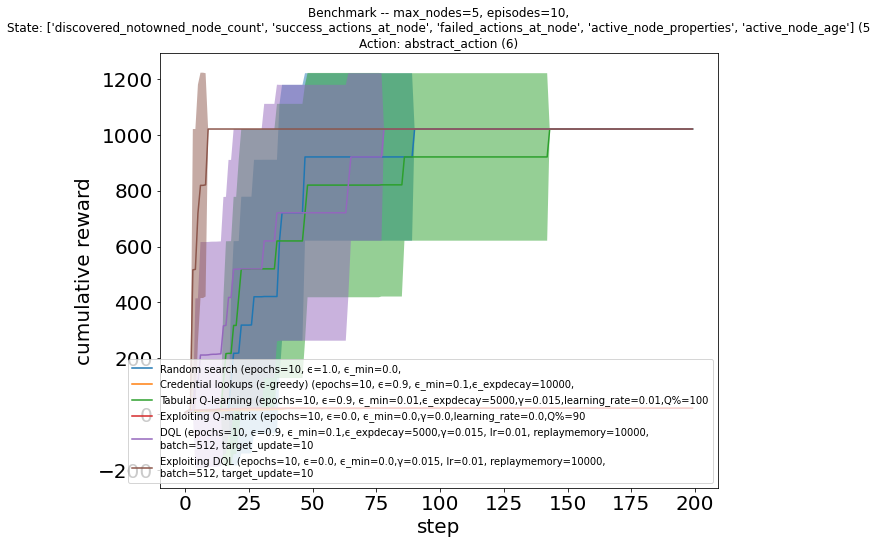

In [13]:
# Compare and plot results for all the agents
all_runs = [
    random_run,
    credlookup_run,
    tabularq_run,
    tabularq_exploit_run,
    dql_run,
    dql_exploit_run
]

# Plot averaged cumulative rewards for DQL vs Random vs DQL-Exploit
themodel = dqla.CyberBattleStateActionModel(ep)
p.plot_averaged_cummulative_rewards(
    all_runs=all_runs,
    title=f'Benchmark -- max_nodes={ep.maximum_node_count}, episodes={eval_episode_count},\n'
    f'State: {[f.name() for f in themodel.state_space.feature_selection]} '
    f'({len(themodel.state_space.feature_selection)}\n'
    f"Action: abstract_action ({themodel.action_space.flat_size()})")

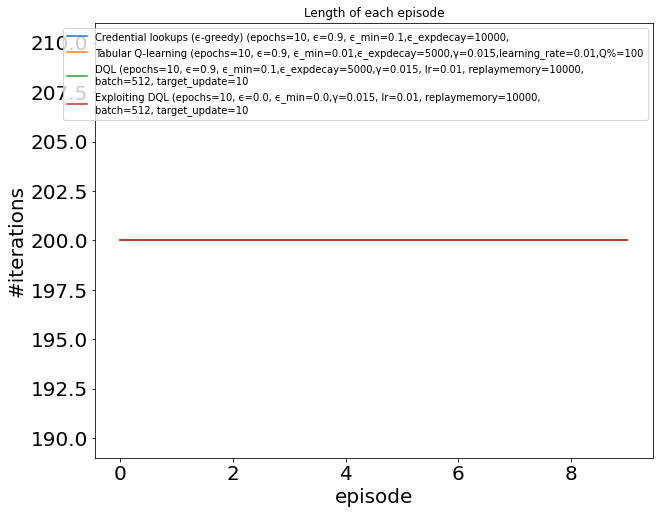

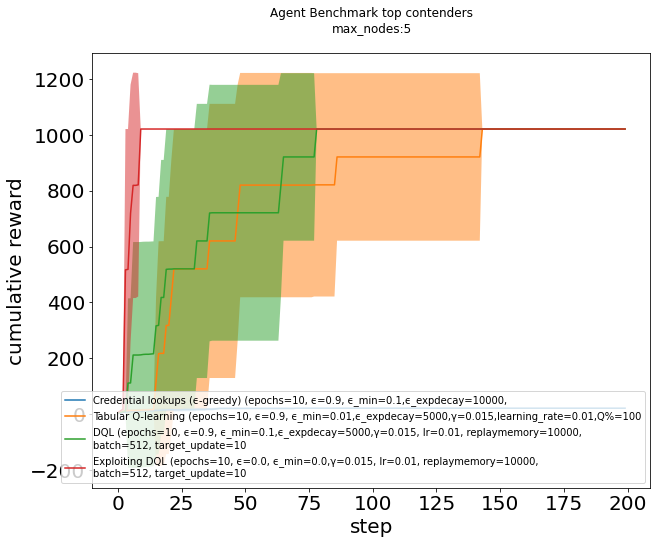

In [14]:
contenders = [
    credlookup_run,
    tabularq_run,
    dql_run,
    dql_exploit_run
]
p.plot_episodes_length(contenders)
p.plot_averaged_cummulative_rewards(
    title=f'Agent Benchmark top contenders\n'
    f'max_nodes:{ep.maximum_node_count}\n',
    all_runs=contenders)

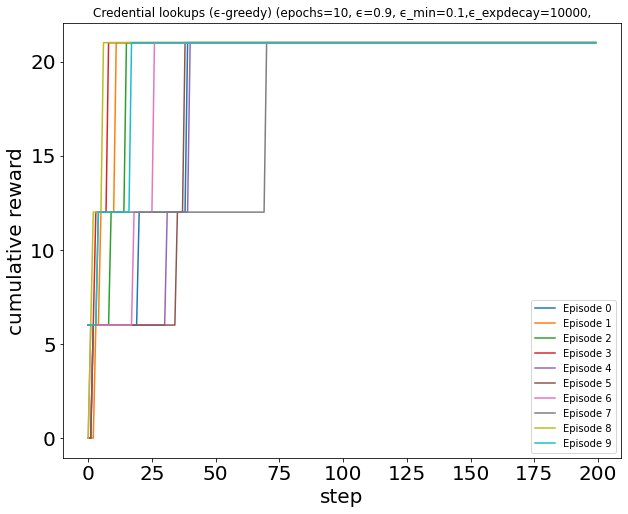

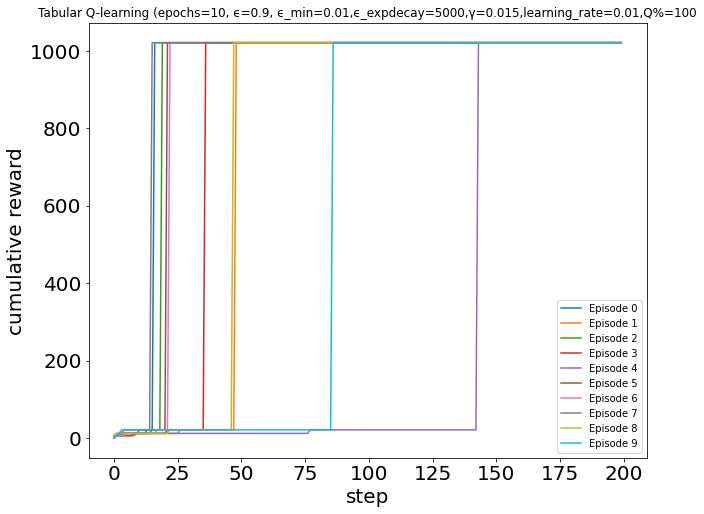

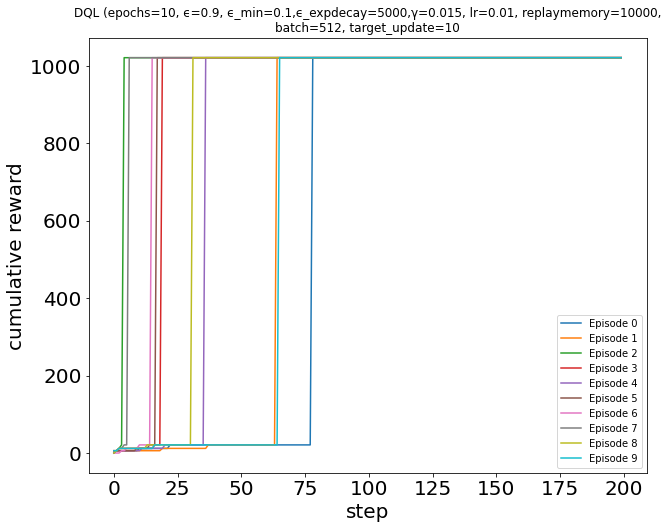

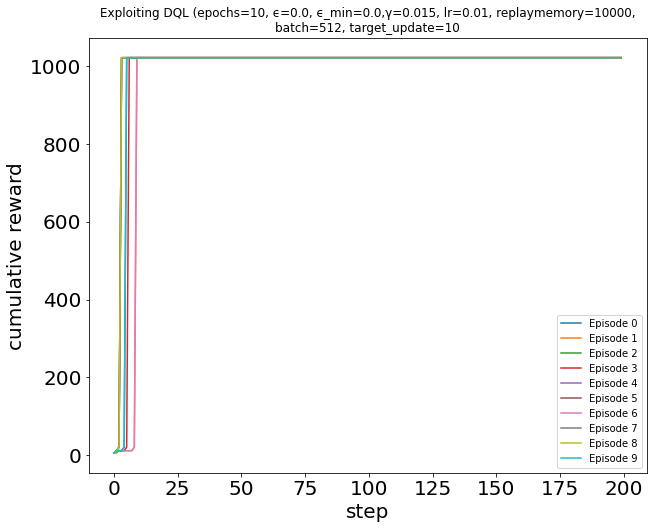

In [15]:
# Plot cumulative rewards for all episodes
for r in contenders:
    p.plot_all_episodes(r)